In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import uproot
import awkward as ak
%matplotlib inline


data_path = "/dipc/elena/WCTE_2025_commissioning/root_files/PMTs_calib/WCTE_offline_R2519S0P4.root"      #signal
control_path = "/dipc/elena/WCTE_2025_commissioning/root_files/PMTs_calib/WCTE_offline_R2519S0P4.root"    #control 
tree ="WCTEReadoutWindows"
n_events = 1000

data_tree = uproot.open(f"{data_path}:{tree}")
control_tree = uproot.open(f"{control_path}:{tree}")

data = data_tree.arrays(entry_stop = n_events, library="ak")
control = control_tree.arrays(entry_stop = n_events, library="ak")

In [18]:
print("TTree", data_tree)
print("branches", sorted(data.fields))
print("n_events", len(data["event_number"]))
n_events = len(data["event_number"])

for branch in data.fields:
    if "waveform" in branch.lower():
        print(branch)

TTree <TTree 'WCTEReadoutWindows' (34 branches) at 0x7f3b95170d10>
branches ['beamline_pmt_qdc_charges', 'beamline_pmt_qdc_ids', 'beamline_pmt_tdc_ids', 'beamline_pmt_tdc_times', 'event_number', 'hit_mpmt_card_ids', 'hit_mpmt_slot_ids', 'hit_pmt_channel_ids', 'hit_pmt_charges', 'hit_pmt_position_ids', 'hit_pmt_times', 'led_card_ids', 'led_counters', 'led_dacsettings', 'led_event_types', 'led_gains', 'led_ids', 'led_sequence_numbers', 'led_slot_numbers', 'led_types', 'pmt_waveform_mpmt_card_ids', 'pmt_waveform_mpmt_slot_ids', 'pmt_waveform_pmt_channel_ids', 'pmt_waveform_pmt_position_ids', 'pmt_waveform_times', 'pmt_waveforms', 'readout_number', 'run_id', 'spill_counter', 'sub_run_id', 'trigger_times', 'trigger_types', 'window_time']
n_events 1000
pmt_waveform_mpmt_card_ids
pmt_waveform_pmt_channel_ids
pmt_waveform_mpmt_slot_ids
pmt_waveform_pmt_position_ids
pmt_waveform_times
pmt_waveforms


In [ ]:
print(data["pmt_waveform_mpmt_card_ids"][0])
print("# hits event 1:", len(data["pmt_waveform_mpmt_card_ids"][0]))

[76, 76, 76, 76, 76, 76, 76, 76, 76, 76, ... 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]
# hits event 1: 1608


In [20]:
waveforms = data["pmt_waveforms"]
card_ids = data["pmt_waveform_mpmt_card_ids"]
slot_ids = data["pmt_waveform_mpmt_slot_ids"]
channel_ids = data["pmt_waveform_pmt_channel_ids"]
times = data["pmt_waveform_times"]


from collections import defaultdict

waveforms_per_pmt = defaultdict(list)

for event_waveforms, event_card_ids, event_slot_ids, event_channel_ids in zip(waveforms, card_ids, slot_ids, channel_ids):
    for wf, cid, sid, chid in zip(event_waveforms, event_card_ids, event_slot_ids, event_channel_ids):
        if sid == -1 or cid > 120:
            continue
        pmt_id = (int(cid), int(sid), int(chid))
        wf_np = np.array(wf)
        baseline = np.mean(wf_np[:10])  # Baseline subtraction
        wf_corrected = wf_np - baseline
        # Invert if needed (optional, depending on polarity):
        # wf_corrected = -wf_corrected
        waveforms_per_pmt[pmt_id].append(wf_corrected)  #Stored as numpy array

In [21]:
for pmt_id, wf_list in waveforms_per_pmt.items():
    print(f"PMT {pmt_id} has {len(wf_list)} events")

PMT (76, 86, 0) has 1000 events
PMT (76, 86, 1) has 1000 events
PMT (76, 86, 2) has 1000 events
PMT (76, 86, 3) has 1000 events
PMT (76, 86, 4) has 1000 events
PMT (76, 86, 5) has 1000 events
PMT (76, 86, 6) has 1000 events
PMT (76, 86, 7) has 1000 events
PMT (76, 86, 8) has 1000 events
PMT (76, 86, 9) has 1000 events
PMT (76, 86, 10) has 1000 events
PMT (76, 86, 11) has 1000 events
PMT (76, 86, 12) has 1000 events
PMT (76, 86, 13) has 1000 events
PMT (76, 86, 14) has 1000 events
PMT (76, 86, 15) has 1000 events
PMT (76, 86, 16) has 1000 events
PMT (76, 86, 17) has 1000 events
PMT (76, 86, 18) has 1000 events
PMT (31, 54, 0) has 1000 events
PMT (31, 54, 1) has 1000 events
PMT (31, 54, 2) has 1000 events
PMT (31, 54, 3) has 1000 events
PMT (31, 54, 4) has 1000 events
PMT (31, 54, 5) has 1000 events
PMT (31, 54, 6) has 1000 events
PMT (31, 54, 7) has 1000 events
PMT (31, 54, 8) has 1000 events
PMT (31, 54, 9) has 1000 events
PMT (31, 54, 10) has 1000 events
PMT (31, 54, 11) has 1000 even

In [22]:
mpmts = set((cid, sid) for (cid, sid, chid) in waveforms_per_pmt.keys())
print(f"Number of unique mPMTs: {len(mpmts)}")  # de 128 mPMTs que se supone que se instalaron (?)

print(f"Number of unique PMTs: {len(waveforms_per_pmt)}")    #83 X 19 = 1577

Number of unique mPMTs: 82
Number of unique PMTs: 1548


In [23]:
charges_per_pmt = defaultdict(list)

for pmt_id, wf_list in waveforms_per_pmt.items():
    for wf in wf_list:
        peak_idx = np.argmax(wf)   #find the peak index per waveform 
        start = max(peak_idx - 5, 0)
        end = min(peak_idx + 3, len(wf))  # +3 includes up to peak+2
        charge = np.sum(wf[start:end])
        charges_per_pmt[pmt_id].append(charge)

In [24]:
chosen_card_id = 29
chosen_slot_id = 50
chosen_mPMT = (chosen_card_id, chosen_slot_id)
pmts_in_mpmt = [(cid, sid, chid) for (cid, sid, chid) in waveforms_per_pmt if (cid, sid) == chosen_mPMT]

print(f"PMTs found in mPMT {chosen_mPMT}: {len(pmts_in_mpmt)}")
for pid in pmts_in_mpmt:
    print(f"PMT {pid} has {len(waveforms_per_pmt[pid])} waveforms")

PMTs found in mPMT (29, 50): 19
PMT (29, 50, 0) has 1000 waveforms
PMT (29, 50, 1) has 1000 waveforms
PMT (29, 50, 2) has 1000 waveforms
PMT (29, 50, 3) has 1000 waveforms
PMT (29, 50, 4) has 1000 waveforms
PMT (29, 50, 5) has 1000 waveforms
PMT (29, 50, 6) has 1000 waveforms
PMT (29, 50, 7) has 1000 waveforms
PMT (29, 50, 8) has 1000 waveforms
PMT (29, 50, 9) has 1000 waveforms
PMT (29, 50, 10) has 1000 waveforms
PMT (29, 50, 11) has 1000 waveforms
PMT (29, 50, 12) has 1000 waveforms
PMT (29, 50, 13) has 1000 waveforms
PMT (29, 50, 14) has 1000 waveforms
PMT (29, 50, 15) has 1000 waveforms
PMT (29, 50, 16) has 1000 waveforms
PMT (29, 50, 17) has 1000 waveforms
PMT (29, 50, 18) has 1000 waveforms


In [35]:
# === CONTROL: Extract pedestal charges ===
control_waveforms_per_pmt = defaultdict(list)
control_charges_per_pmt = defaultdict(list)

for event_waveforms, event_card_ids, event_slot_ids, event_channel_ids in zip(control["pmt_waveforms"], 
                                                                              control["pmt_waveform_mpmt_card_ids"], 
                                                                              control["pmt_waveform_mpmt_slot_ids"], 
                                                                              control["pmt_waveform_pmt_channel_ids"]):
    for wf, cid, sid, chid in zip(event_waveforms, event_card_ids, event_slot_ids, event_channel_ids):
        if sid == -1 or cid > 120:
            continue
        pmt_id = (int(cid), int(sid), int(chid))
        wf_np = np.array(wf)
        baseline = np.mean(wf_np[:10])
        wf_corrected = wf_np - baseline
        control_waveforms_per_pmt[pmt_id].append(wf_corrected)
        # Integrate baseline fluctuation (should just give pedestal charge)
        peak_idx = np.argmax(wf_corrected)
        start = max(peak_idx - 5, 0)
        end = min(peak_idx + 3, len(wf_corrected))
        charge = np.sum(wf_corrected[start:end])
        control_charges_per_pmt[pmt_id].append(charge)


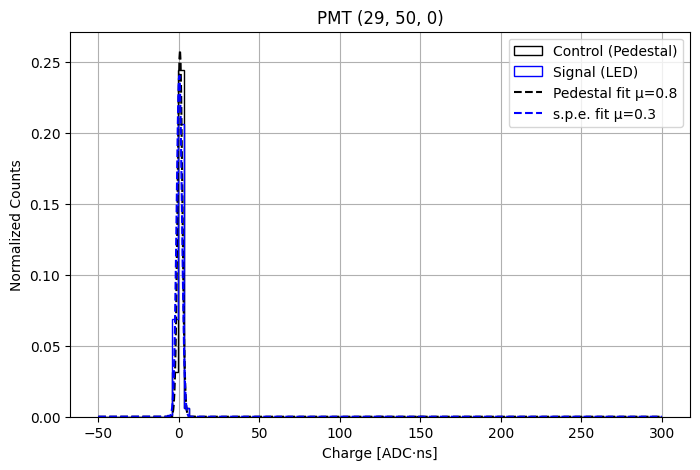

Gain for PMT (29, 50, 0): -0.42 ADC·ns


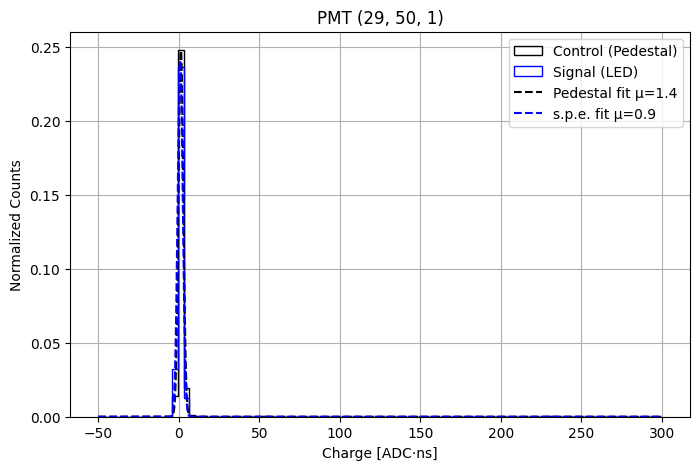

Gain for PMT (29, 50, 1): -0.44 ADC·ns


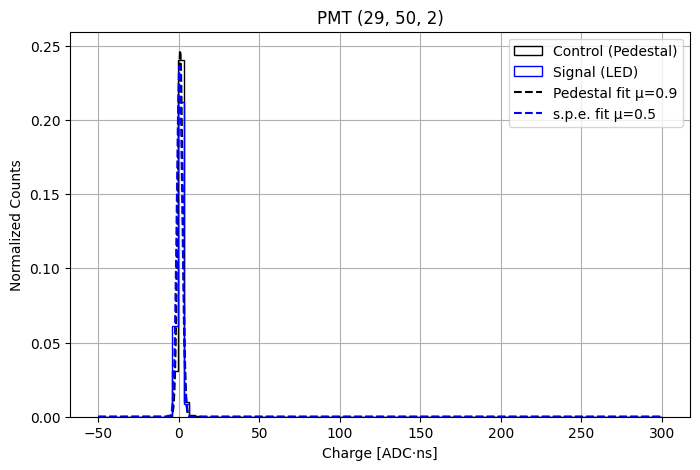

Gain for PMT (29, 50, 2): -0.40 ADC·ns


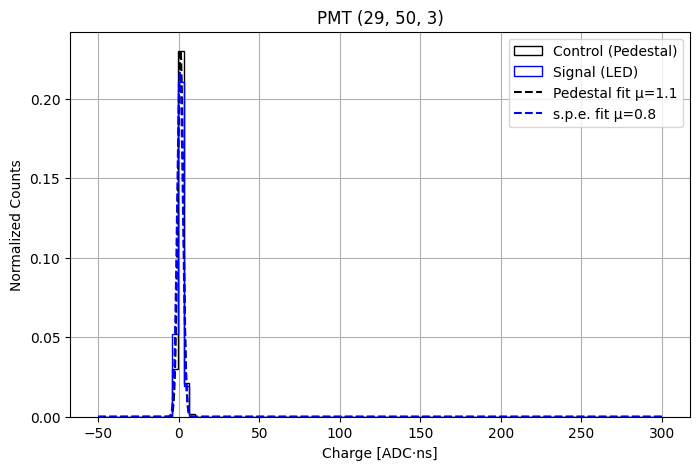

Gain for PMT (29, 50, 3): -0.32 ADC·ns


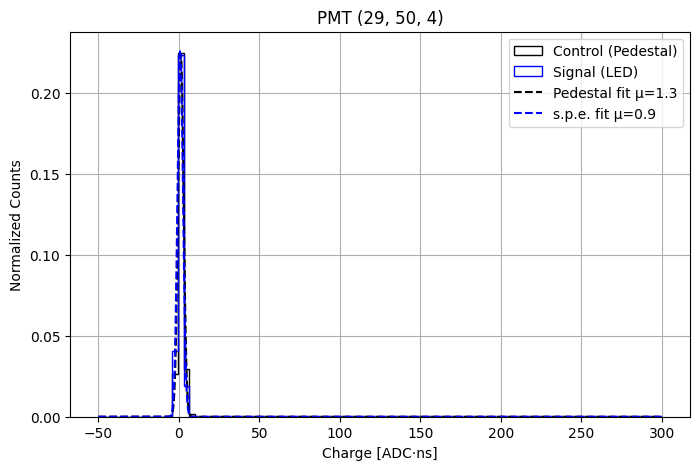

Gain for PMT (29, 50, 4): -0.37 ADC·ns


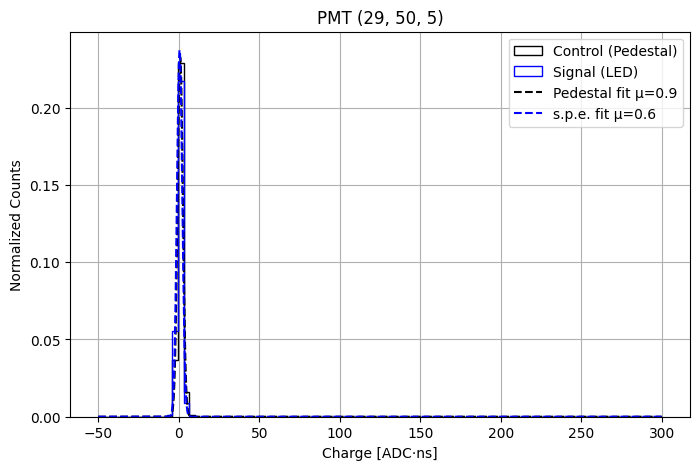

Gain for PMT (29, 50, 5): -0.37 ADC·ns


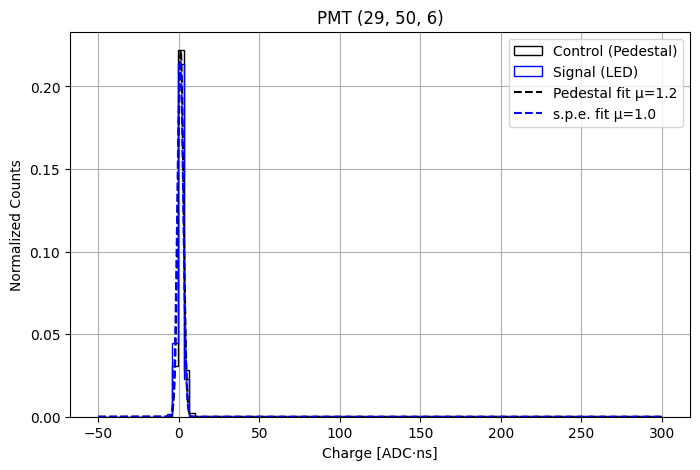

Gain for PMT (29, 50, 6): -0.27 ADC·ns


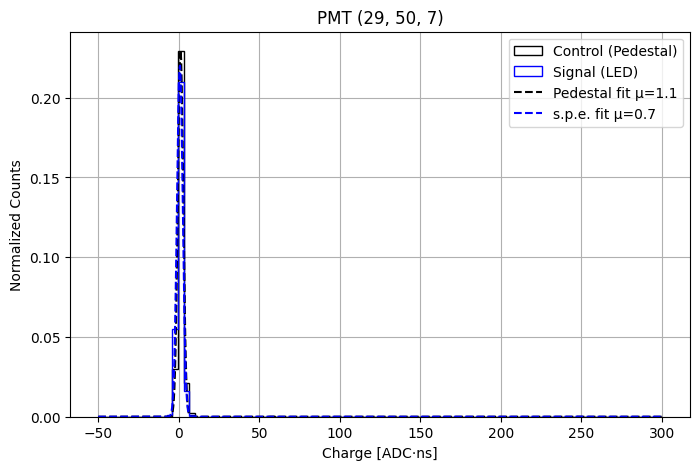

Gain for PMT (29, 50, 7): -0.42 ADC·ns


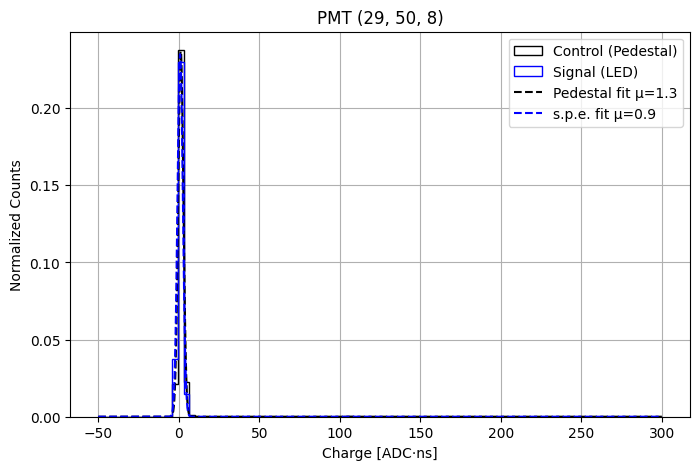

Gain for PMT (29, 50, 8): -0.38 ADC·ns


/scratch/scicomp/easybuild/CentOS/7.3.1611/Haswell/software/SciPy-bundle/2019.10-foss-2019b-Python-3.7.4/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


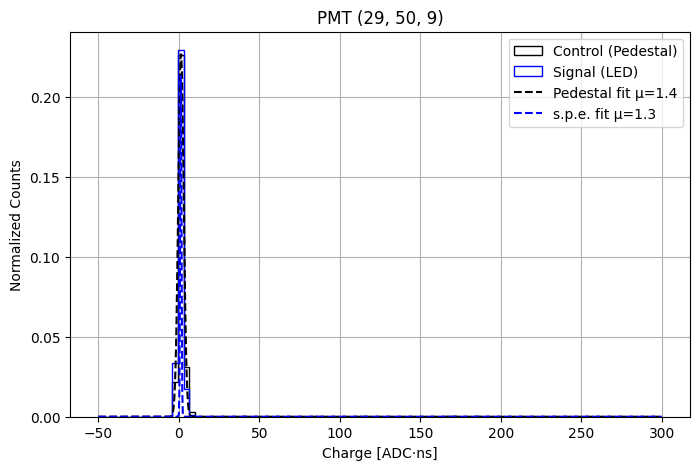

Gain for PMT (29, 50, 9): -0.10 ADC·ns


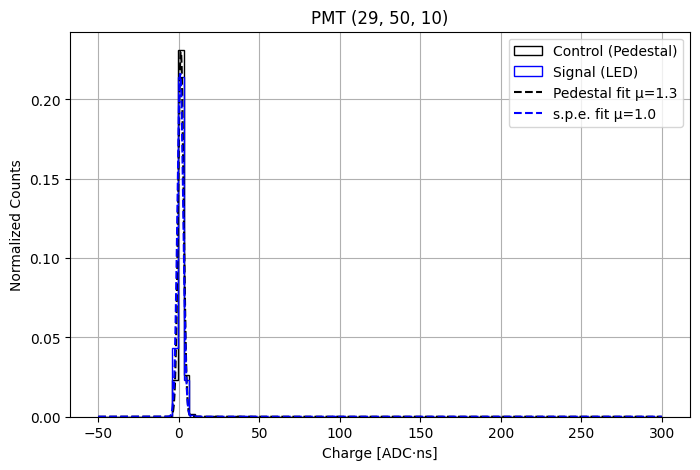

Gain for PMT (29, 50, 10): -0.35 ADC·ns


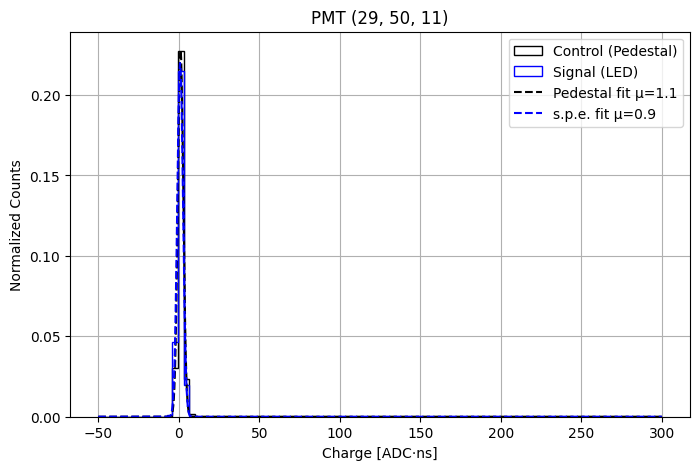

Gain for PMT (29, 50, 11): -0.27 ADC·ns


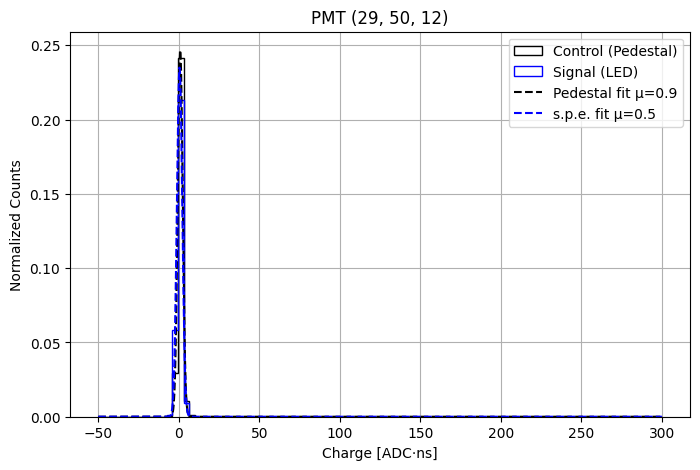

Gain for PMT (29, 50, 12): -0.40 ADC·ns


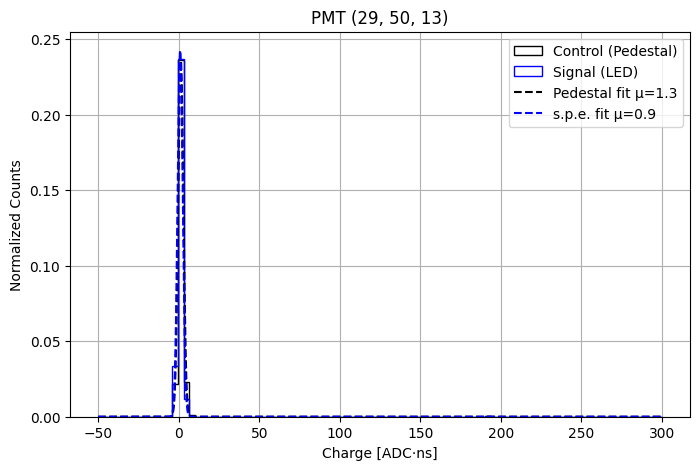

Gain for PMT (29, 50, 13): -0.39 ADC·ns


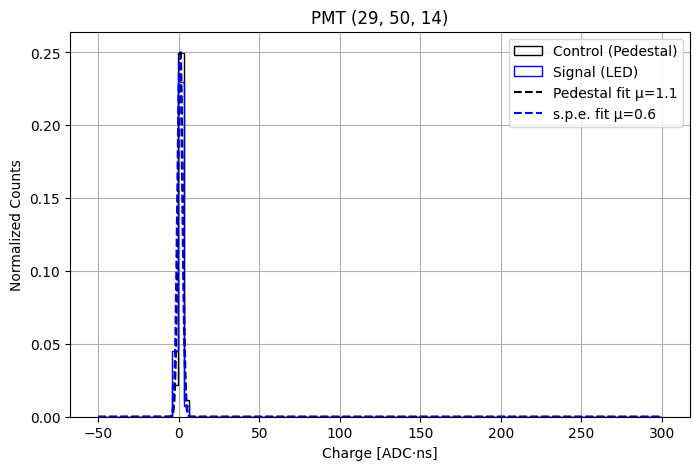

Gain for PMT (29, 50, 14): -0.43 ADC·ns


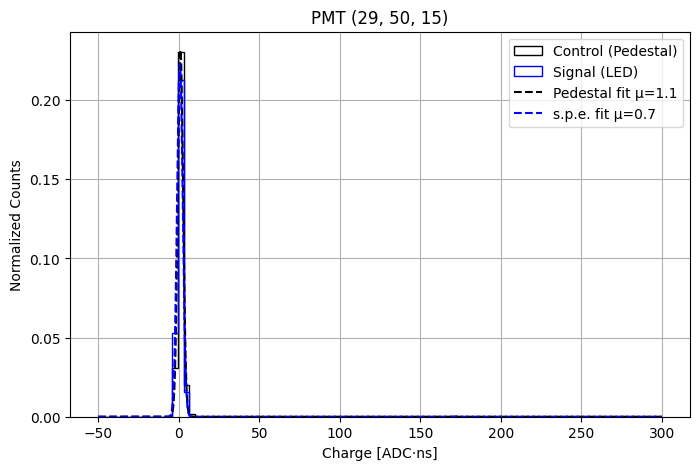

Gain for PMT (29, 50, 15): -0.37 ADC·ns


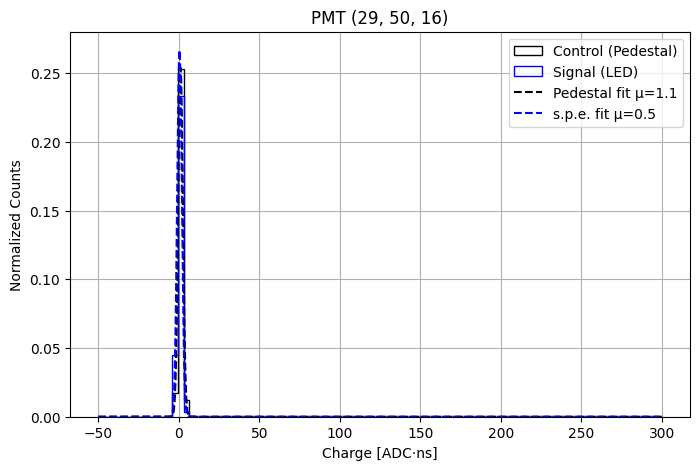

Gain for PMT (29, 50, 16): -0.64 ADC·ns


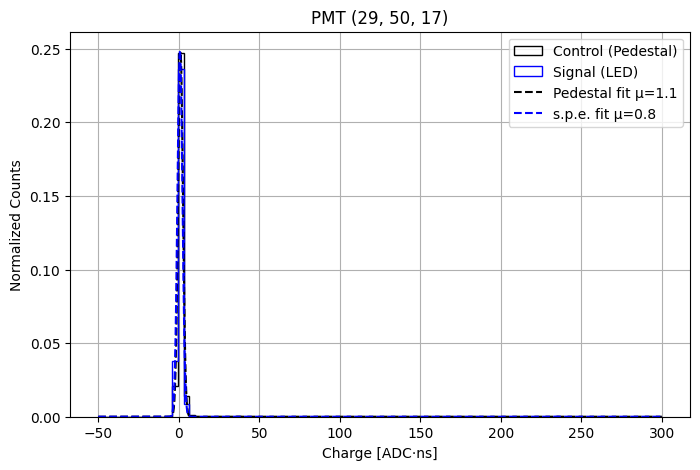

Gain for PMT (29, 50, 17): -0.37 ADC·ns


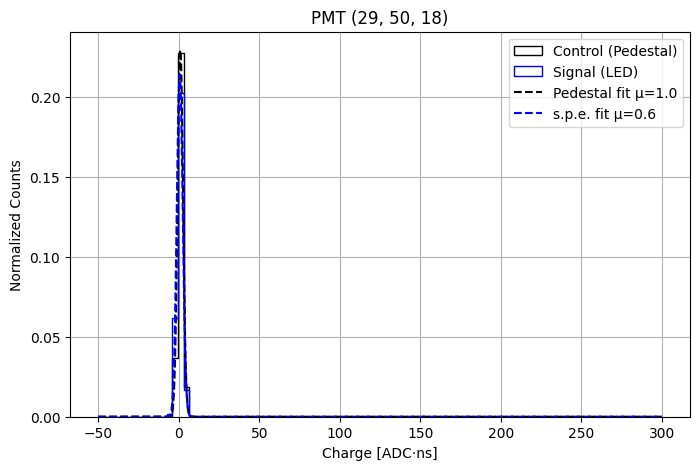

Gain for PMT (29, 50, 18): -0.36 ADC·ns


In [36]:
# === Plot for one PMT in your chosen mPMT ===
from scipy.optimize import curve_fit

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

for pid in pmts_in_mpmt:
    control_q = control_charges_per_pmt[pid]
    signal_q = charges_per_pmt[pid]  # from earlier

    plt.figure(figsize=(8,5))
    bins = np.linspace(-50, 300, 100)

    plt.hist(control_q, bins=bins, histtype='step', label='Control (Pedestal)', color='black', density=True)
    plt.hist(signal_q, bins=bins, histtype='step', label='Signal (LED)', color='blue', density=True)

    # Fit pedestal in control
    hist_vals, bin_edges = np.histogram(control_q, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    popt_ped, _ = curve_fit(gaussian, bin_centers, hist_vals, p0=[1, np.mean(control_q), np.std(control_q)])

    # Fit s.p.e. in signal
    hist_vals_s, _ = np.histogram(signal_q, bins=bins, density=True)
    popt_spe, _ = curve_fit(gaussian, bin_centers, hist_vals_s, p0=[1, np.mean(signal_q), np.std(signal_q)])

    x_fit = np.linspace(-50, 300, 1000)
    plt.plot(x_fit, gaussian(x_fit, *popt_ped), 'k--', label=f'Pedestal fit μ={popt_ped[1]:.1f}')
    plt.plot(x_fit, gaussian(x_fit, *popt_spe), 'b--', label=f's.p.e. fit μ={popt_spe[1]:.1f}')

    plt.title(f"PMT {pid}")
    plt.xlabel("Charge [ADC·ns]")
    plt.ylabel("Normalized Counts")
    plt.legend()
    plt.grid()
    plt.show()

    # Optional: print gain
    gain = popt_spe[1] - popt_ped[1]
    print(f"Gain for PMT {pid}: {gain:.2f} ADC·ns")

In [25]:
# Define control window bins, e.g. bins 10 to 30 (adjust as needed)
control_start = 10
control_end = 30

charges_per_pmt = defaultdict(list)

for pmt_id, wf_list in waveforms_per_pmt.items():
    for wf in wf_list:
        wf_np = np.array(wf)
        # Compute baseline as mean of control window samples
        baseline = np.mean(wf_np[control_start:control_end])
        wf_corrected = wf_np - baseline

        # Define signal integration window around peak (e.g., peak - 5 to peak + 3)
        peak_idx = np.argmax(wf_corrected)
        start = max(peak_idx - 5, 0)
        end = min(peak_idx + 3, len(wf_corrected))

        # Integrate charge in corrected waveform in the signal window
        charge = np.sum(wf_corrected[start:end])
        charges_per_pmt[pmt_id].append(charge)

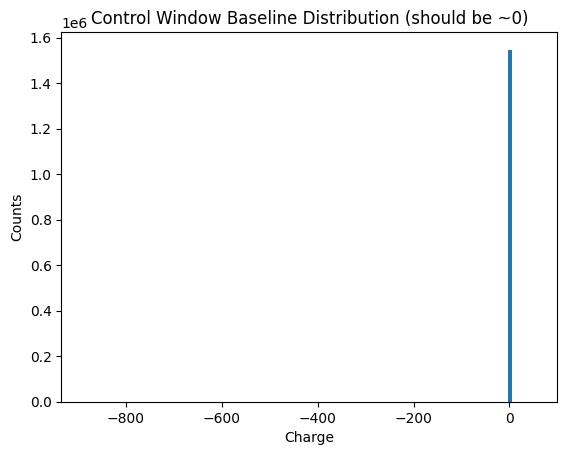

In [26]:
control_charges = []

for pmt_id, wf_list in waveforms_per_pmt.items():
    for wf in wf_list:
        wf_np = np.array(wf)
        baseline = np.mean(wf_np[control_start:control_end])
        control_charges.append(baseline)

plt.hist(control_charges, bins=100)
plt.title("Control Window Baseline Distribution (should be ~0)")
plt.xlabel("Charge")
plt.ylabel("Counts")
plt.show()

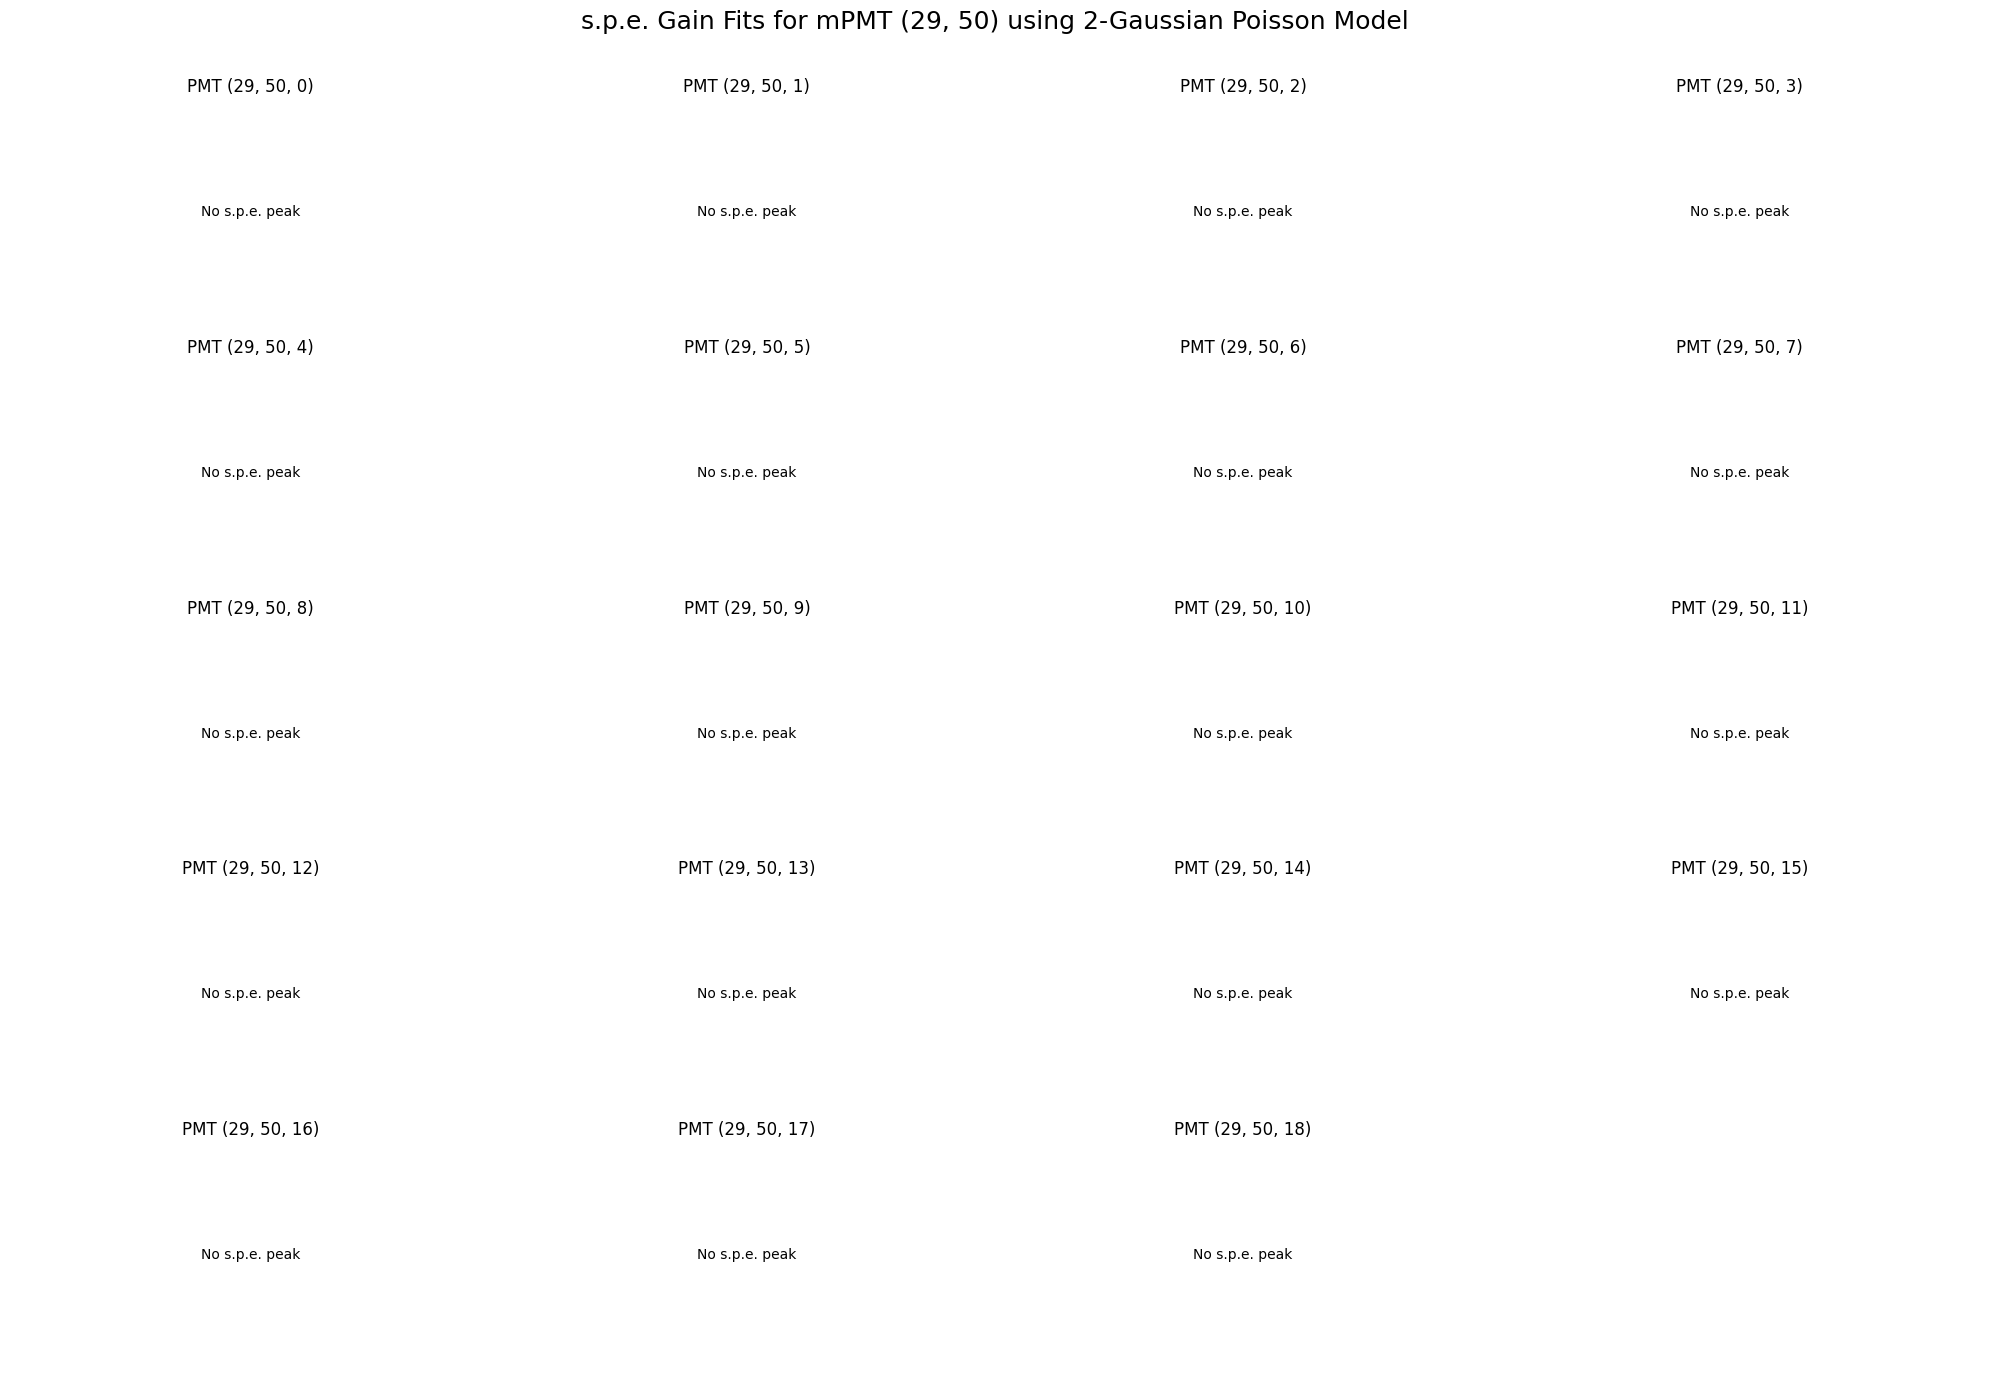


== s.p.e. Gain Estimates (μₛ) per PMT ==
PMT (29, 50, 0): No s.p.e. peak
PMT (29, 50, 1): No s.p.e. peak
PMT (29, 50, 2): No s.p.e. peak
PMT (29, 50, 3): No s.p.e. peak
PMT (29, 50, 4): No s.p.e. peak
PMT (29, 50, 5): No s.p.e. peak
PMT (29, 50, 6): No s.p.e. peak
PMT (29, 50, 7): No s.p.e. peak
PMT (29, 50, 8): No s.p.e. peak
PMT (29, 50, 9): No s.p.e. peak
PMT (29, 50, 10): No s.p.e. peak
PMT (29, 50, 11): No s.p.e. peak
PMT (29, 50, 12): No s.p.e. peak
PMT (29, 50, 13): No s.p.e. peak
PMT (29, 50, 14): No s.p.e. peak
PMT (29, 50, 15): No s.p.e. peak
PMT (29, 50, 16): No s.p.e. peak
PMT (29, 50, 17): No s.p.e. peak
PMT (29, 50, 18): No s.p.e. peak


In [27]:
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from scipy.stats import poisson

# Model: pedestal + 1 s.p.e. Gaussian weighted by Poisson probabilities
def spe_model(x, lam, mu_c, sig_c, mu_s, sig_s):
    P0 = poisson.pmf(0, lam)
    P1 = poisson.pmf(1, lam)
    return (
        P0 * np.exp(-0.5 * ((x - mu_c) / sig_c) ** 2) / (sig_c * np.sqrt(2 * np.pi)) +
        P1 * np.exp(-0.5 * ((x - mu_s) / sig_s) ** 2) / (sig_s * np.sqrt(2 * np.pi))
    ) * len(x)  # scale roughly for plotting

# Fit results
spe_results = {}

fig, axes = plt.subplots(5, 4, figsize=(20, 14))
axes = axes.flatten()

for idx, pmt_id in enumerate(pmts_in_mpmt):
    ax = axes[idx]
    charges = np.array(charges_per_pmt.get(pmt_id, []))

    if len(charges) < 100:
        ax.text(0.5, 0.5, "Too few entries", ha='center', va='center')
        ax.set_title(f"PMT {pmt_id}")
        ax.axis('off')
        spe_results[pmt_id] = ("Too few entries", None)
        continue

    # Histogram and smoothing
    hist, bins = np.histogram(charges, bins=200, range=(0, np.percentile(charges, 99)))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    hist_smooth = gaussian_filter1d(hist, sigma=2)

    # Estimate μ_s guess from post-pedestal peak
    signal_mask = bin_centers > 60  # ignore pedestal region
    if not np.any(signal_mask):
        ax.text(0.5, 0.5, "No s.p.e. peak", ha='center', va='center')
        ax.set_title(f"PMT {pmt_id}")
        ax.axis('off')
        spe_results[pmt_id] = ("No s.p.e. peak", None)
        continue

    peak_idx = np.argmax(hist_smooth[signal_mask])
    mu_s_guess = bin_centers[signal_mask][peak_idx]
    mu_s_guess = np.clip(mu_s_guess, 30, 300)

    # Fit over valid charge range
    fit_mask = (bin_centers > 0) & (bin_centers < np.percentile(charges, 99.5))
    x_fit = bin_centers[fit_mask]
    y_fit = hist[fit_mask]

    try:
        expected_lambda = 0.24  # Jakob's typical value
        mu_c_guess = 0
        sigma_c_guess = 10
        sigma_s_guess = 30

        popt, _ = curve_fit(
            spe_model, x_fit, y_fit,
            p0=[expected_lambda, mu_c_guess, sigma_c_guess, mu_s_guess, sigma_s_guess],
            bounds=([0.01, -50, 1, 10, 5], [1.0, 50, 100, 600, 100]),
        )
        lam_fit, mu_c, sig_c, mu_s, sig_s = popt

        # Plot
        ax.hist(charges, bins=200, histtype='step', label='Data')
        ax.plot(x_fit, spe_model(x_fit, *popt), color='darkorange', label='Fit')
        ax.axvline(mu_s, color='orange', linestyle='--', label=f'μₛ = {mu_s:.1f}')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(left=10)
        ax.set_ylim(bottom=1e-1)
        ax.set_title(f"PMT {pmt_id}")
        ax.legend(fontsize=6)

        spe_results[pmt_id] = (mu_s, lam_fit)

    except RuntimeError:
        ax.text(0.5, 0.5, "Fit failed", ha='center', va='center')
        ax.set_title(f"PMT {pmt_id}")
        ax.axis('off')
        spe_results[pmt_id] = ("Fit failed", None)

# Hide unused subplots
for j in range(len(pmts_in_mpmt), len(axes)):
    axes[j].axis('off')

fig.suptitle(f"s.p.e. Gain Fits for mPMT {chosen_mPMT} using 2-Gaussian Poisson Model", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# === Summary ===
print("\n== s.p.e. Gain Estimates (μₛ) per PMT ==")
for pmt, result in spe_results.items():
    if isinstance(result[0], str):
        print(f"PMT {pmt}: {result[0]}")
    else:
        mu_s, lam = result
        print(f"PMT {pmt}: μₛ = {mu_s:.2f} ADC·ns, λ = {lam:.2f}")


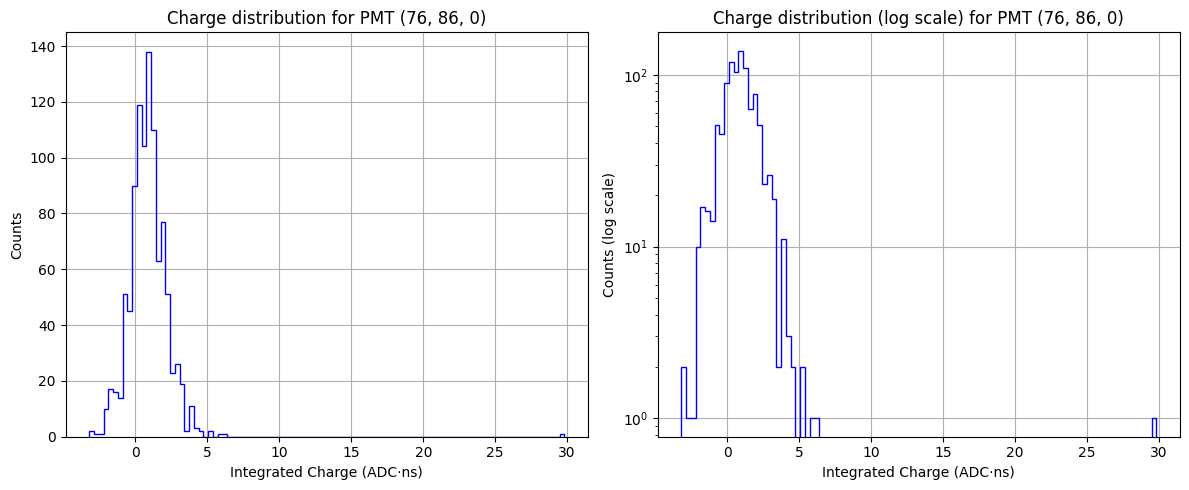

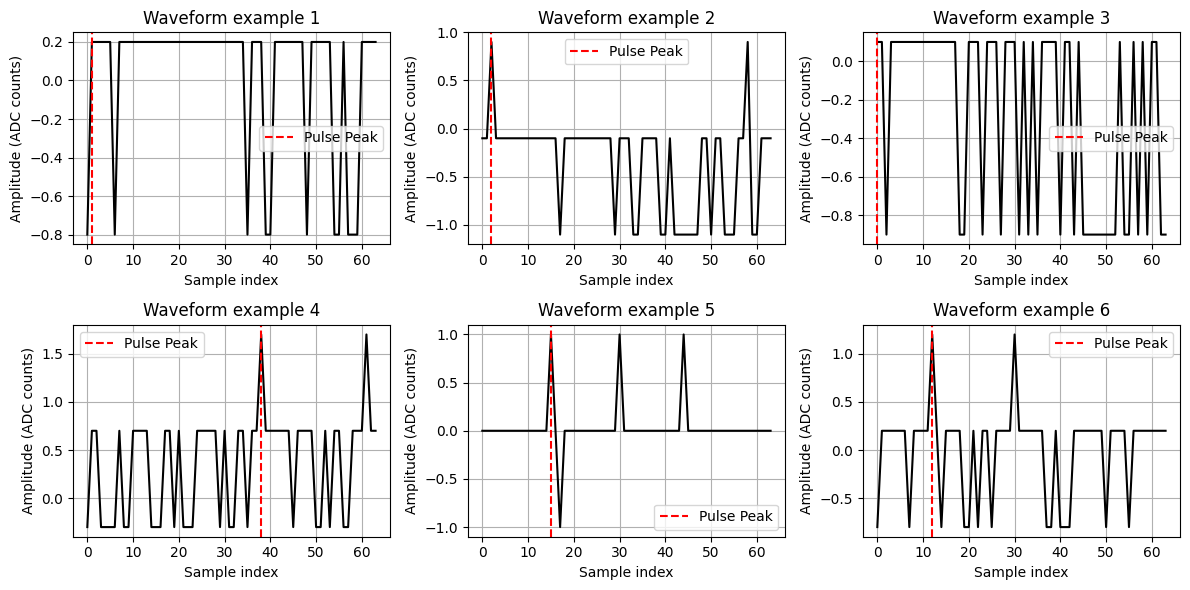

In [28]:
# Pick one PMT to visualize (choose any from your keys)
example_pmt = list(charges_per_pmt.keys())[0]

# Charges for this PMT
charges = np.array(charges_per_pmt[example_pmt])

# 1) Plot charge histogram (linear + log y-scale)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(charges, bins=100, histtype='step', color='blue')
plt.title(f"Charge distribution for PMT {example_pmt}")
plt.xlabel("Integrated Charge (ADC·ns)")
plt.ylabel("Counts")
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(charges, bins=100, histtype='step', color='blue', log=True)
plt.title(f"Charge distribution (log scale) for PMT {example_pmt}")
plt.xlabel("Integrated Charge (ADC·ns)")
plt.ylabel("Counts (log scale)")
plt.grid(True)

plt.tight_layout()
plt.show()

# 2) Plot example raw waveforms: some noise-only, some with pulses
wf_list = waveforms_per_pmt[example_pmt]

plt.figure(figsize=(12,6))

n_examples = 6
for i in range(n_examples):
    plt.subplot(2, 3, i+1)
    plt.plot(wf_list[i], color='black')
    plt.axvline(np.argmax(wf_list[i]), color='red', linestyle='--', label='Pulse Peak')
    plt.title(f"Waveform example {i+1}")
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude (ADC counts)")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

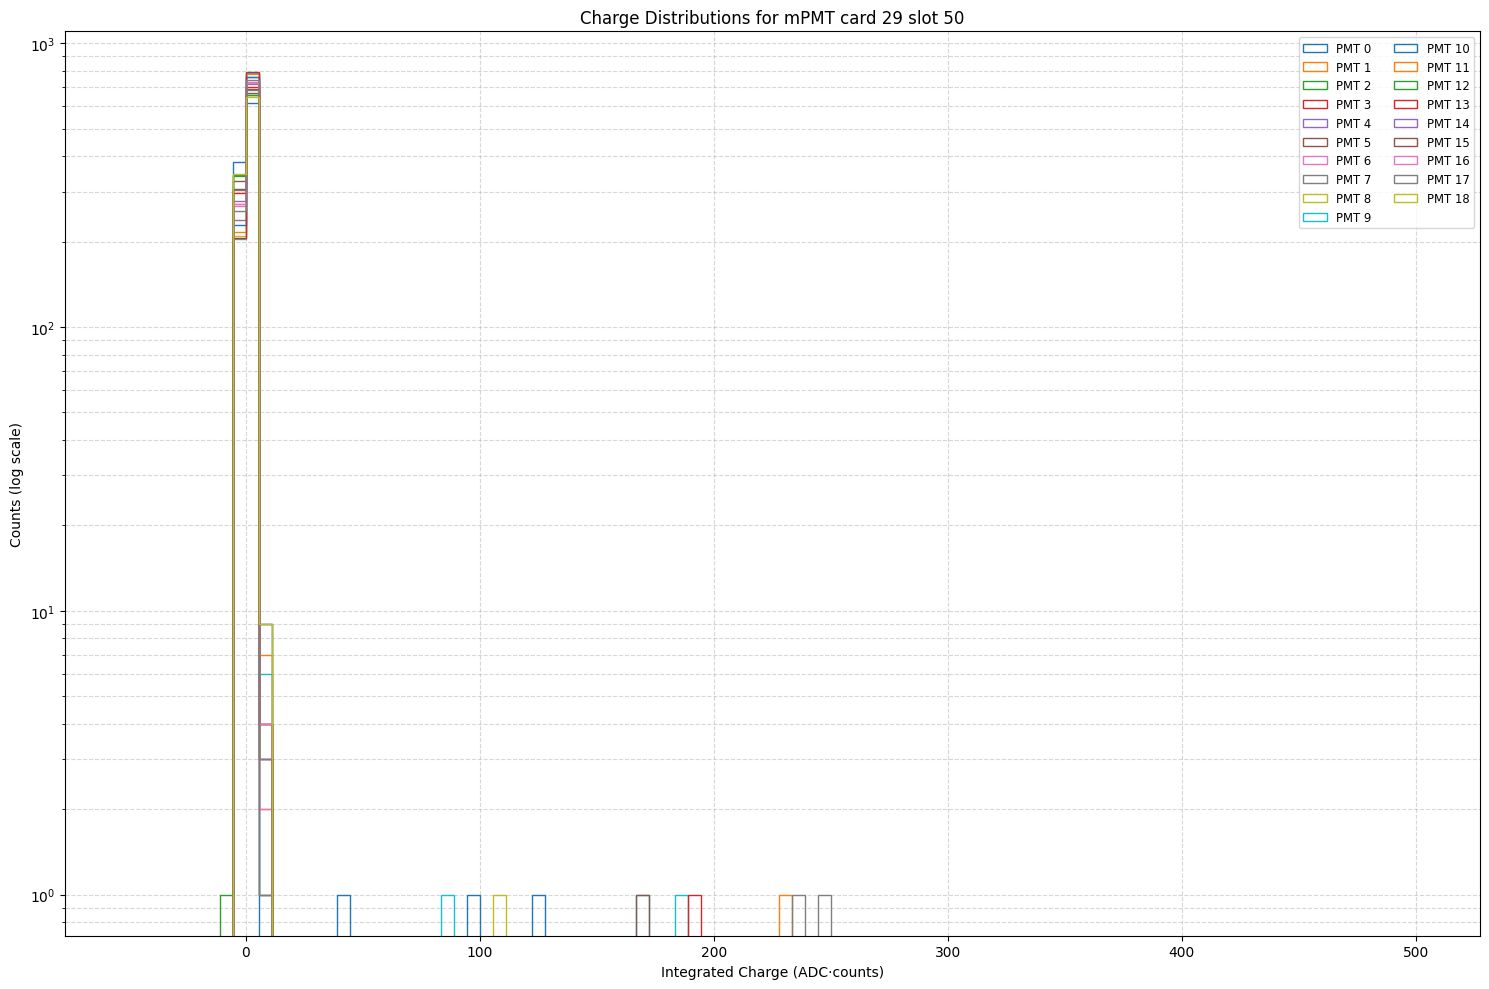

In [29]:

# Replace these with the mPMT you want to plot:
target_card_id = 29
target_slot_id = 50

# Get the list of PMTs belonging to the target mPMT
pmts_in_mpmts = [pmt for pmt in charges_per_pmt if pmt[0] == target_card_id and pmt[1] == target_slot_id]

plt.figure(figsize=(15, 10))

bins = np.linspace(-50, 500, 100)  # Adjust binning to your charge range

for pmt in sorted(pmts_in_mpmts, key=lambda x: x[2]):  # sort by channel_id (3rd tuple element)
    charges = charges_per_pmt[pmt]
    if len(charges) == 0:
        continue
    plt.hist(charges, bins=bins, histtype='step', label=f'PMT {pmt[2]}')

plt.yscale('log')
plt.xlabel('Integrated Charge (ADC·counts)')
plt.ylabel('Counts (log scale)')
plt.title(f'Charge Distributions for mPMT card {target_card_id} slot {target_slot_id}')
plt.legend(loc='upper right', ncol=2, fontsize='small')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [30]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

gain_results = {}

# Define the fitting range for the s.p.e. peak (adjust as needed)
fit_min, fit_max = 150, 250

for pmt in sorted(pmts_in_mpmts, key=lambda x: x[2]):
    charges = np.array(charges_per_pmt[pmt])
    if len(charges) == 0:
        print(f"PMT {pmt}: No charges")
        continue
    
    # Histogram the charges
    counts, bin_edges = np.histogram(charges, bins=100, range=(-50, 500))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Select bins in the fitting range (s.p.e. peak)
    fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
    x_fit = bin_centers[fit_mask]
    y_fit = counts[fit_mask]
    
    # Skip if not enough data
    if np.sum(y_fit) < 10:
        print(f"PMT {pmt}: Not enough data in s.p.e. peak region")
        continue
    
    # Initial guesses: amplitude=max count, mean ~200, sigma ~20
    p0 = [np.max(y_fit), 200, 20]
    
    try:
        popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=p0)
        amp_fit, mu_fit, sigma_fit = popt
        gain_results[pmt] = mu_fit
        print(f"PMT {pmt}: Gain (μ_s) = {mu_fit:.2f} ADC·counts")
    except RuntimeError:
        print(f"PMT {pmt}: Fit failed")


PMT (29, 50, 0): Not enough data in s.p.e. peak region
PMT (29, 50, 1): Not enough data in s.p.e. peak region
PMT (29, 50, 2): Not enough data in s.p.e. peak region
PMT (29, 50, 3): Not enough data in s.p.e. peak region
PMT (29, 50, 4): Not enough data in s.p.e. peak region
PMT (29, 50, 5): Not enough data in s.p.e. peak region
PMT (29, 50, 6): Not enough data in s.p.e. peak region
PMT (29, 50, 7): Not enough data in s.p.e. peak region
PMT (29, 50, 8): Not enough data in s.p.e. peak region
PMT (29, 50, 9): Not enough data in s.p.e. peak region
PMT (29, 50, 10): Not enough data in s.p.e. peak region
PMT (29, 50, 11): Not enough data in s.p.e. peak region
PMT (29, 50, 12): Not enough data in s.p.e. peak region
PMT (29, 50, 13): Not enough data in s.p.e. peak region
PMT (29, 50, 14): Not enough data in s.p.e. peak region
PMT (29, 50, 15): Not enough data in s.p.e. peak region
PMT (29, 50, 16): Not enough data in s.p.e. peak region
PMT (29, 50, 17): Not enough data in s.p.e. peak region
PM

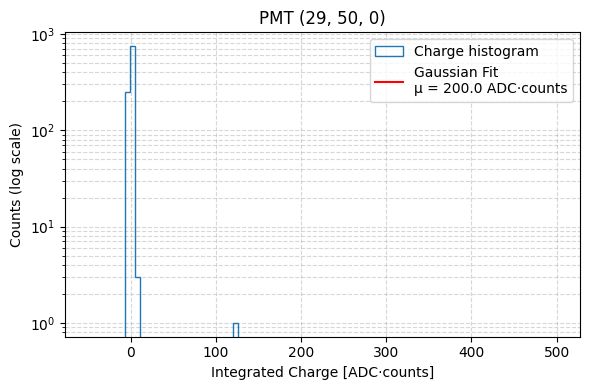

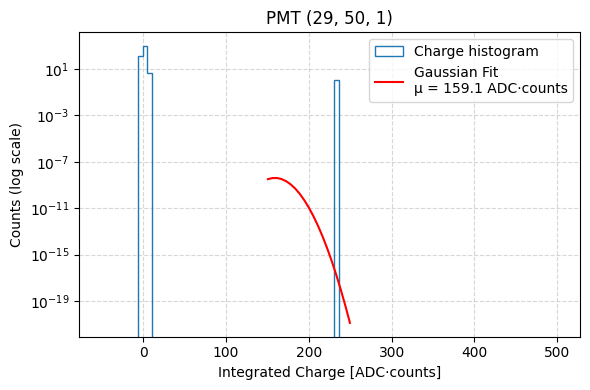

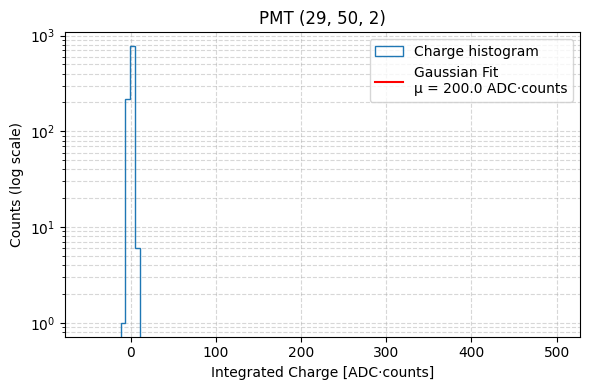

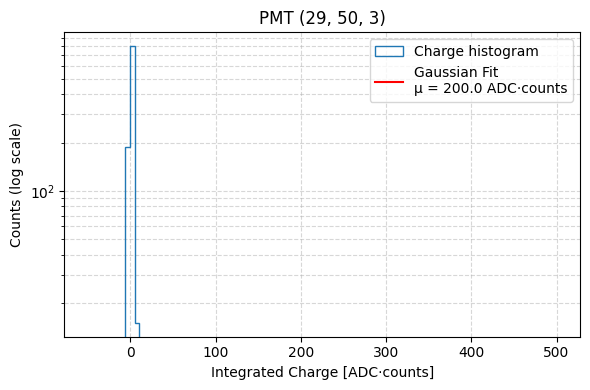

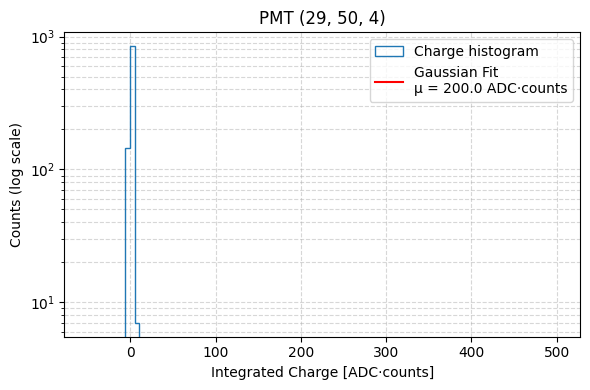

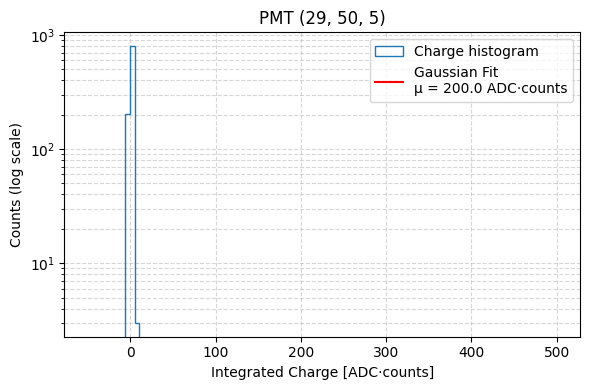

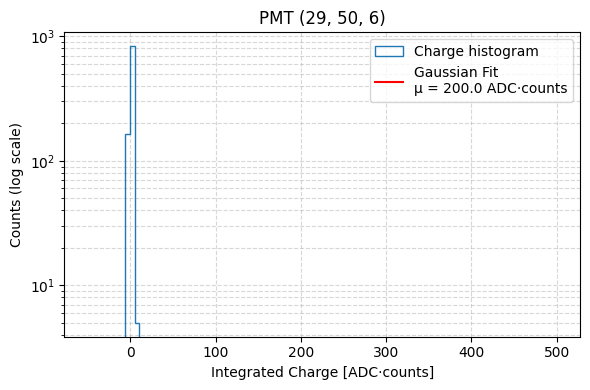

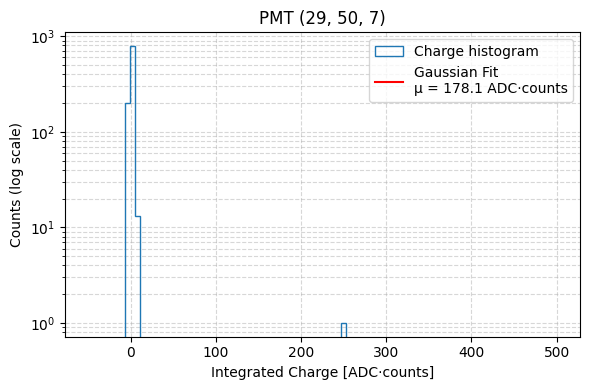

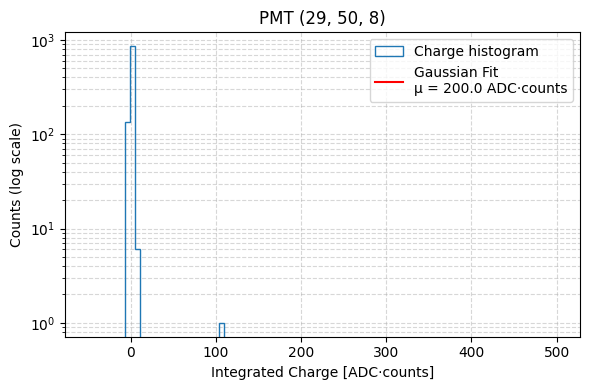

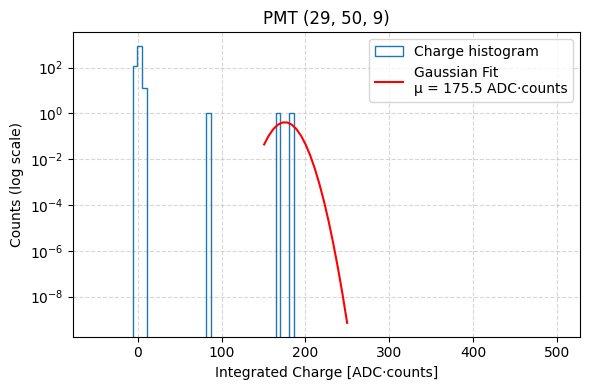

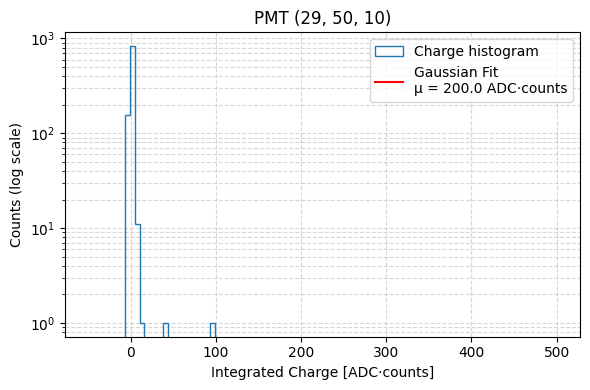

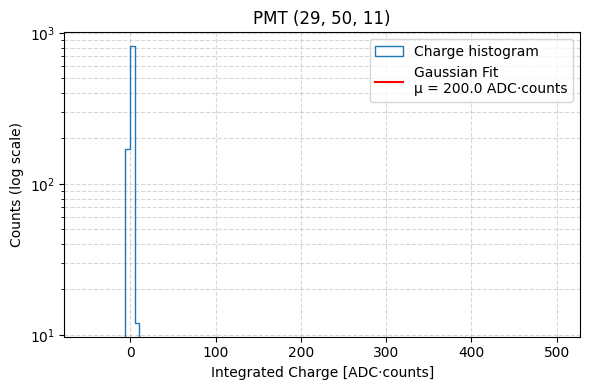

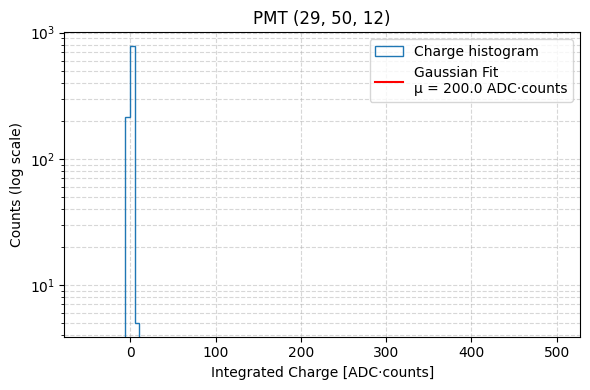

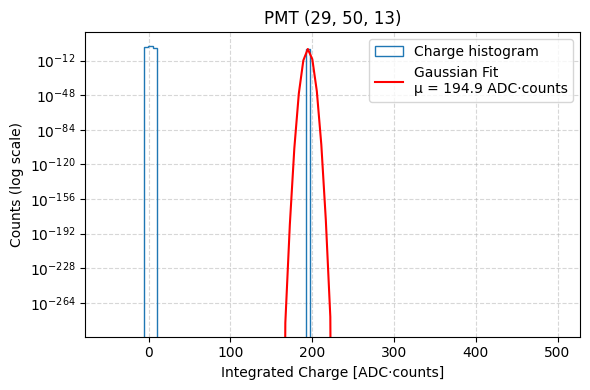

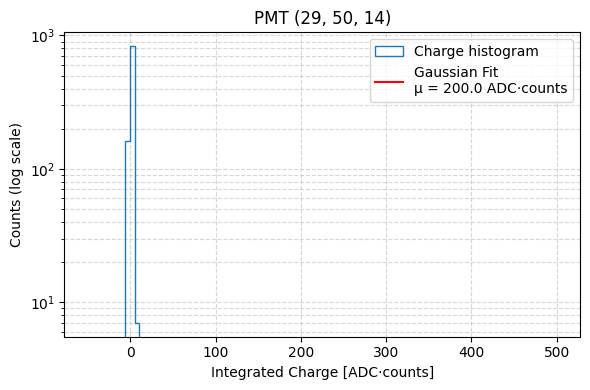

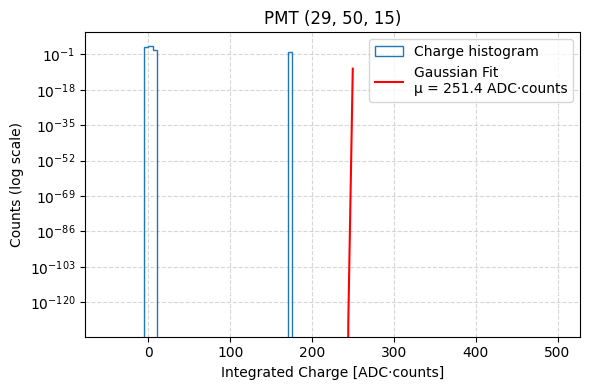

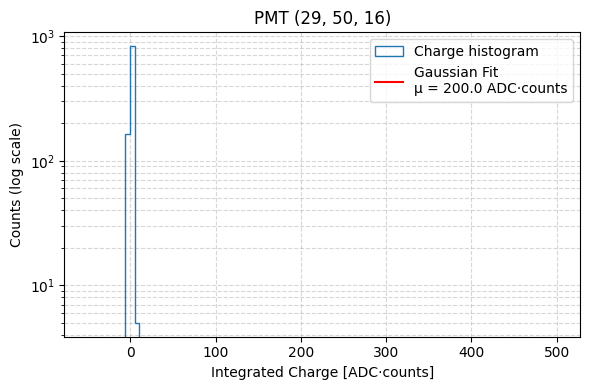

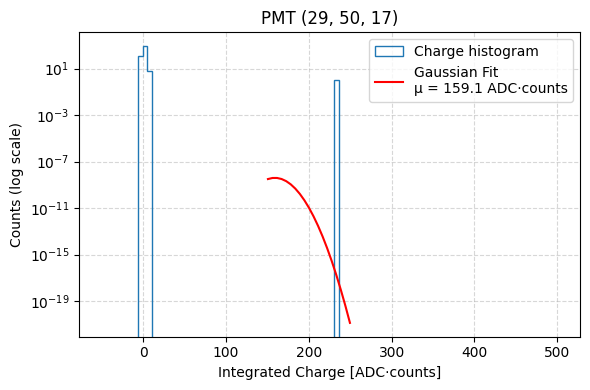

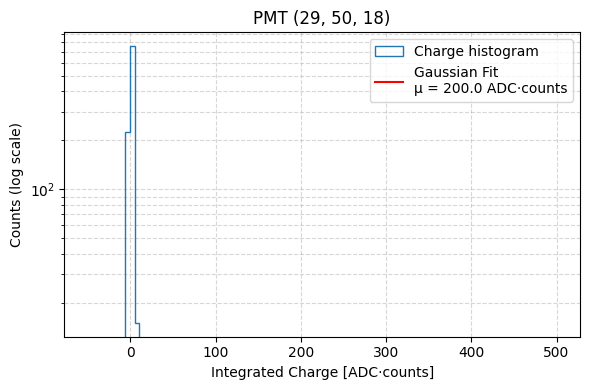

In [31]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))

gain_results = {}

fit_min, fit_max = 150, 250  # Range to fit s.p.e. peak

for pmt in sorted(pmts_in_mpmts, key=lambda x: x[2]):
    charges = np.array(charges_per_pmt[pmt])
    if len(charges) == 0:
        print(f"PMT {pmt}: No charges")
        continue

    # Histogram
    counts, bin_edges = np.histogram(charges, bins=100, range=(-50, 500))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit range
    fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
    x_fit = bin_centers[fit_mask]
    y_fit = counts[fit_mask]

    # Initial guess
    p0 = [np.max(y_fit), 200, 20]

    try:
        popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=p0)
        amp_fit, mu_fit, sigma_fit = popt
        gain_results[pmt] = mu_fit

        # Plot
        
        plt.figure(figsize=(6, 4))
        plt.hist(charges, bins=100, range=(-50, 500), histtype='step', label='Charge histogram', log=True)
        plt.plot(x_fit, gaussian(x_fit, *popt), 'r-', label=f'Gaussian Fit\nμ = {mu_fit:.1f} ADC·counts')
        plt.xlabel("Integrated Charge [ADC·counts]")
        plt.ylabel("Counts (log scale)")
        plt.title(f"PMT {pmt}")
        plt.legend()
        plt.grid(True, which='both', ls='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    except RuntimeError:
        print(f"PMT {pmt}: Fit failed")

In [32]:
from scipy.optimize import curve_fit
from scipy.stats import poisson

def pedestal_plus_spe(x, mu, xs, sigmas, xc, sigmac):
    p0 = poisson.pmf(0, mu)
    p1 = poisson.pmf(1, mu)
    gauss_0pe = p0 * np.exp(-0.5 * ((x - xc) / sigmac)**2) / (sigmac * np.sqrt(2 * np.pi))
    gauss_1pe = p1 * np.exp(-0.5 * ((x - xs) / sigmas)**2) / (sigmas * np.sqrt(2 * np.pi))
    return gauss_0pe + gauss_1pe

gain_results = {}
fit_min, fit_max = 100, 300  # fit from ~half SPE to above peak

for pmt in sorted(pmts_in_mpmts, key=lambda x: x[2]):
    charges = np.array(charges_per_pmt[pmt])
    if len(charges) == 0:
        print(f"PMT {pmt}: No charges")
        continue

    # Histogram
    counts, bin_edges = np.histogram(charges, bins=120, range=(-100, 500))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    total_area = np.sum(counts)

    # Fit range
    fit_mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
    x_fit = bin_centers[fit_mask]
    y_fit = counts[fit_mask] / total_area  # normalize to PDF

    if np.sum(y_fit) < 0.01:
        print(f"PMT {pmt}: Too few counts in fit region")
        continue

    # Initial guesses
    mu_guess = 0.1
    xs_guess = x_fit[np.argmax(y_fit)]
    p0 = [mu_guess, xs_guess, 20.0, 0.0, 5.0]

    try:
        popt, _ = curve_fit(pedestal_plus_spe, x_fit, y_fit, p0=p0)
        mu, xs, sigmas, xc, sigmac = popt
        gain_results[pmt] = {
            "gain (μs)": xs,
            "λ": mu,
            "σ_spe": sigmas,
            "σ_ped": sigmac
        }

        # Plot
        plt.figure(figsize=(6, 4))
        #plt.hist(charges, bins=120, range=(-100, 500), histtype='step', label='Charge Histogram', log=True, density=True)
        counts, bin_edges = np.histogram(charges, bins=120, range=(-100, 500), density=True)
        counts += 1e-6  # avoid log(0)
        plt.step((bin_edges[:-1] + bin_edges[1:]) / 2, counts, where='mid', label='Charge Histogram')
        plt.yscale('log')

        plt.plot(x_fit, pedestal_plus_spe(x_fit, *popt), 'r-', label=f'Fit\nμₛ={xs:.1f} ADC·counts\nλ={mu:.2f}')
        plt.ylim(bottom=1e-6)
        plt.xlabel("Integrated Charge [ADC·counts]")
        plt.ylabel("Normalized Counts (log scale)")
        plt.title(f"PMT {pmt}")
        plt.grid(True, which='both', ls='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except RuntimeError:
        print(f"PMT {pmt}: Fit failed")
    

# After your fit loop ends, create a DataFrame:
df_gain = pd.DataFrame.from_dict(gain_results, orient='index')

# Rename index as PMT columns (tuple unpack)
df_gain.index.name = 'PMT (card,slot,channel)'

# Optional: reorder columns if you want
df_gain = df_gain[['gain (μs)', 'λ', 'σ_spe', 'σ_ped']]

# Display table
print(df_gain)

# If you want, save to CSV:
# df_gain.to_csv('WCTE_PMT_gain_results.csv')



PMT (29, 50, 0): Too few counts in fit region
PMT (29, 50, 1): Too few counts in fit region
PMT (29, 50, 2): Too few counts in fit region
PMT (29, 50, 3): Too few counts in fit region
PMT (29, 50, 4): Too few counts in fit region
PMT (29, 50, 5): Too few counts in fit region
PMT (29, 50, 6): Too few counts in fit region
PMT (29, 50, 7): Too few counts in fit region
PMT (29, 50, 8): Too few counts in fit region
PMT (29, 50, 9): Too few counts in fit region
PMT (29, 50, 10): Too few counts in fit region
PMT (29, 50, 11): Too few counts in fit region
PMT (29, 50, 12): Too few counts in fit region
PMT (29, 50, 13): Too few counts in fit region
PMT (29, 50, 14): Too few counts in fit region
PMT (29, 50, 15): Too few counts in fit region
PMT (29, 50, 16): Too few counts in fit region
PMT (29, 50, 17): Too few counts in fit region
PMT (29, 50, 18): Too few counts in fit region


KeyError: "None of [Index(['gain (μs)', 'λ', 'σ_spe', 'σ_ped'], dtype='object')] are in the [columns]"

In [ ]:
print("== Refined s.p.e. Gain Estimates (μₛ) per PMT ==")
for pmt, res in gain_results.items():
    print(f"PMT {pmt}: μₛ = {res['gain (μs)']:.2f} ADC·ns, λ = {res['λ']:.2f}")

== Refined s.p.e. Gain Estimates (μₛ) per PMT ==
PMT (29, 50, 1): μₛ = 184.49 ADC·ns, λ = 1.00
PMT (29, 50, 2): μₛ = 179.11 ADC·ns, λ = 1.00
PMT (29, 50, 3): μₛ = 202.78 ADC·ns, λ = 1.00
PMT (29, 50, 4): μₛ = 131.56 ADC·ns, λ = 1.00
PMT (29, 50, 5): μₛ = 166.99 ADC·ns, λ = 1.00
PMT (29, 50, 6): μₛ = 215.68 ADC·ns, λ = 1.00
PMT (29, 50, 7): μₛ = 201.29 ADC·ns, λ = 1.00
PMT (29, 50, 8): μₛ = 169.12 ADC·ns, λ = 1.00
PMT (29, 50, 9): μₛ = 138.98 ADC·ns, λ = 1.00
PMT (29, 50, 10): μₛ = 186.68 ADC·ns, λ = 1.00
PMT (29, 50, 11): μₛ = 177.81 ADC·ns, λ = 1.00
PMT (29, 50, 12): μₛ = 192.32 ADC·ns, λ = 1.00
PMT (29, 50, 13): μₛ = 161.13 ADC·ns, λ = 1.00
PMT (29, 50, 14): μₛ = 191.70 ADC·ns, λ = 1.00
PMT (29, 50, 15): μₛ = 130.74 ADC·ns, λ = 1.00
PMT (29, 50, 16): μₛ = 153.80 ADC·ns, λ = 1.00
PMT (29, 50, 17): μₛ = 181.83 ADC·ns, λ = 1.00


PMT (29, 50, 0): SPE fit failed


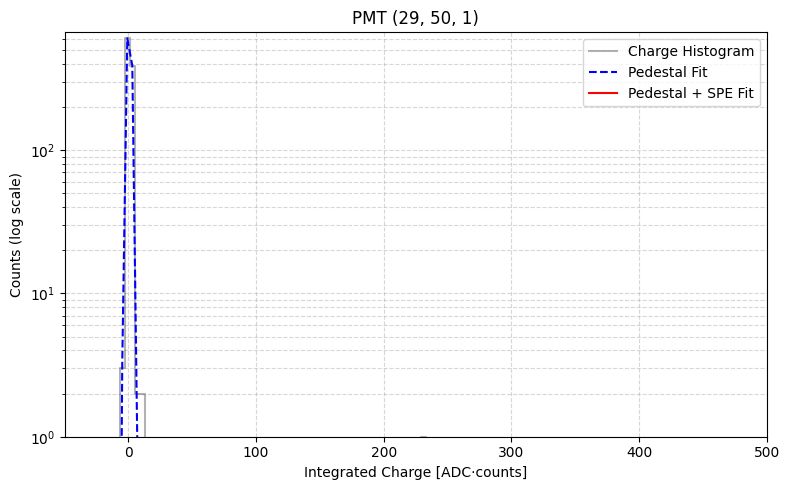

PMT (29, 50, 2): Too few counts in SPE fit region
PMT (29, 50, 3): Too few counts in SPE fit region
PMT (29, 50, 4): Too few counts in SPE fit region
          gain (μs)          λ      σ_spe  xc_pedestal  σ_pedestal
29 50 1  230.892852  65.401628  19.703052     0.766475    1.653267


In [33]:
from scipy.optimize import curve_fit
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def pedestal_only_scaled(x, A_ped, xc, sigmac):
    # A_ped: escala absoluta (número total de eventos pedestal)
    gauss = np.exp(-0.5 * ((x - xc) / sigmac)**2) / (sigmac * np.sqrt(2 * np.pi))
    return A_ped * gauss

def pedestal_plus_spe_scaled(x, A, mu, xs, sigmas, xc, sigmac):
    # A: escala absoluta (total número eventos considerados)
    p0 = poisson.pmf(0, mu)
    p1 = poisson.pmf(1, mu)
    gauss_0pe = p0 * np.exp(-0.5 * ((x - xc) / sigmac)**2) / (sigmac * np.sqrt(2 * np.pi))
    gauss_1pe = p1 * np.exp(-0.5 * ((x - xs) / sigmas)**2) / (sigmas * np.sqrt(2 * np.pi))
    return A * (gauss_0pe + gauss_1pe)

gain_results = {}
fit_min, fit_max = -50, 500
fit_min_ped, fit_max_ped = -50, 50
fit_min_spe, fit_max_spe = 100, 300

pmts_subset = sorted(pmts_in_mpmts, key=lambda x: x[2])[:5]

for pmt in pmts_subset:
    charges = np.array(charges_per_pmt[pmt])
    if len(charges) == 0:
        print(f"PMT {pmt}: No charges")
        continue

    counts, bin_edges = np.histogram(charges, bins=140, range=(fit_min, fit_max))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit pedestal con escala A_ped
    ped_mask = (bin_centers >= fit_min_ped) & (bin_centers <= fit_max_ped)
    x_fit_ped = bin_centers[ped_mask]
    y_fit_ped = counts[ped_mask]

    try:
        p0_ped = [np.max(y_fit_ped), 0, 5]  # A_ped, xc, sigmac
        popt_ped, _ = curve_fit(pedestal_only_scaled, x_fit_ped, y_fit_ped, p0=p0_ped)
        A_ped, xc_ped, sigmac_ped = popt_ped
    except RuntimeError:
        print(f"PMT {pmt}: Pedestal fit failed")
        continue

    # Fit SPE + pedestal con pedestal fijo y escala total A
    spe_mask = (bin_centers >= fit_min_spe) & (bin_centers <= fit_max_spe)
    x_fit_spe = bin_centers[spe_mask]
    y_fit_spe = counts[spe_mask]

    if np.sum(y_fit_spe) < 1:
        print(f"PMT {pmt}: Too few counts in SPE fit region")
        continue

    mu_guess = 0.1
    xs_guess = x_fit_spe[np.argmax(y_fit_spe)]
    sigmas_guess = 20.0
    A_guess = np.sum(y_fit_spe) + A_ped  # total counts aprox

    try:
        fit_func = lambda x, A, mu, xs, sigmas: pedestal_plus_spe_scaled(x, A, mu, xs, sigmas, xc_ped, sigmac_ped)
        popt_spe, _ = curve_fit(fit_func, x_fit_spe, y_fit_spe, p0=[A_guess, mu_guess, xs_guess, sigmas_guess])
        A_fit, mu_fit, xs_fit, sigmas_fit = popt_spe

        gain_results[pmt] = {
            "gain (μs)": xs_fit,
            "λ": mu_fit,
            "σ_spe": sigmas_fit,
            "xc_pedestal": xc_ped,
            "σ_pedestal": sigmac_ped,
            "A_pedestal": A_ped,
            "A_total": A_fit
        }

        # Plot completo
        y_ped_full = pedestal_only_scaled(bin_centers, A_ped, xc_ped, sigmac_ped)
        y_spe_full = pedestal_plus_spe_scaled(bin_centers, A_fit, mu_fit, xs_fit, sigmas_fit, xc_ped, sigmac_ped)

        plt.figure(figsize=(8,5))
        plt.step(bin_centers, counts, where='mid', label='Charge Histogram', color='black', alpha=0.3)
        plt.plot(bin_centers, y_ped_full, 'b--', label='Pedestal Fit')
        plt.plot(bin_centers, y_spe_full, 'r-', label='Pedestal + SPE Fit')
        plt.xlim(fit_min, fit_max)
        plt.yscale('log')
        plt.ylim(1, np.max(counts)*1.1)
        plt.xlabel('Integrated Charge [ADC·counts]')
        plt.ylabel('Counts (log scale)')
        plt.title(f'PMT {pmt}')
        plt.grid(True, which='both', ls='--', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except RuntimeError:
        print(f"PMT {pmt}: SPE fit failed")

df_gain = pd.DataFrame.from_dict(gain_results, orient='index')
df_gain.index.name = 'PMT (card,slot,channel)'
df_gain = df_gain[['gain (μs)', 'λ', 'σ_spe', 'xc_pedestal', 'σ_pedestal']]
print(df_gain)


In [34]:
# === File paths ===
data_path = "/dipc/elena/WCTE_2025_commissioning/root_files/PMTs_calib/WCTE_offline_R2521S0P144.root"      # Signal (LED)
control_path = "/dipc/elena/WCTE_2025_commissioning/root_files/PMTs_calib/WCTE_offline_R2519S0P4.root"   # Control (pedestal)
tree = "WCTEReadoutWindows"
n_events = 1000

# === Load ROOT trees ===
data_tree = uproot.open(f"{data_path}:{tree}")
control_tree = uproot.open(f"{control_path}:{tree}")
data = data_tree.arrays(entry_stop=n_events, library="ak")
control = control_tree.arrays(entry_stop=n_events, library="ak")

# === Choose specific mPMT ===
chosen_mpmt = (29, 50)  # card ID, slot ID

# === Charge extraction function ===
def extract_charges(waveforms, card_ids, slot_ids, channel_ids, mpmt):
    charges = defaultdict(list)
    for ev_wf, ev_cid, ev_sid, ev_chid in zip(waveforms, card_ids, slot_ids, channel_ids):
        for wf, cid, sid, chid in zip(ev_wf, ev_cid, ev_sid, ev_chid):
            if (int(cid), int(sid)) != mpmt:
                continue
            wf = np.array(wf)
            baseline = np.mean(wf[:10])  # subtract baseline
            wf_corr = wf - baseline
            peak_idx = np.argmax(wf_corr)
            start = max(peak_idx - 5, 0)
            end = min(peak_idx + 3, len(wf_corr))
            charge = np.sum(wf_corr[start:end])
            pmt_id = (int(cid), int(sid), int(chid))
            charges[pmt_id].append(charge)
    return charges

# === Extract charges from both files ===
ctrl_charges = extract_charges(
    control["pmt_waveforms"],
    control["pmt_waveform_mpmt_card_ids"],
    control["pmt_waveform_mpmt_slot_ids"],
    control["pmt_waveform_pmt_channel_ids"],
    chosen_mpmt
)

data_charges = extract_charges(
    data["pmt_waveforms"],
    data["pmt_waveform_mpmt_card_ids"],
    data["pmt_waveform_mpmt_slot_ids"],
    data["pmt_waveform_pmt_channel_ids"],
    chosen_mpmt
)


In [ ]:
print("Signal entries:", len(signal))
print("Signal charge range:", np.min(signal), "→", np.max(signal))
print("Control entries:", len(ctrl))
print("Control charge range:", np.min(ctrl), "→", np.max(ctrl))

Signal entries: 1000
Signal charge range: 262.20000000000005 → 3317.3999999999996
Control entries: 1000
Control charge range: -2.0 → 149.20000000000002


Signal entries: 1000
Signal charge range: 262.20000000000005 → 3317.3999999999996
Control entries: 1000
Control charge range: -2.0 → 149.20000000000002


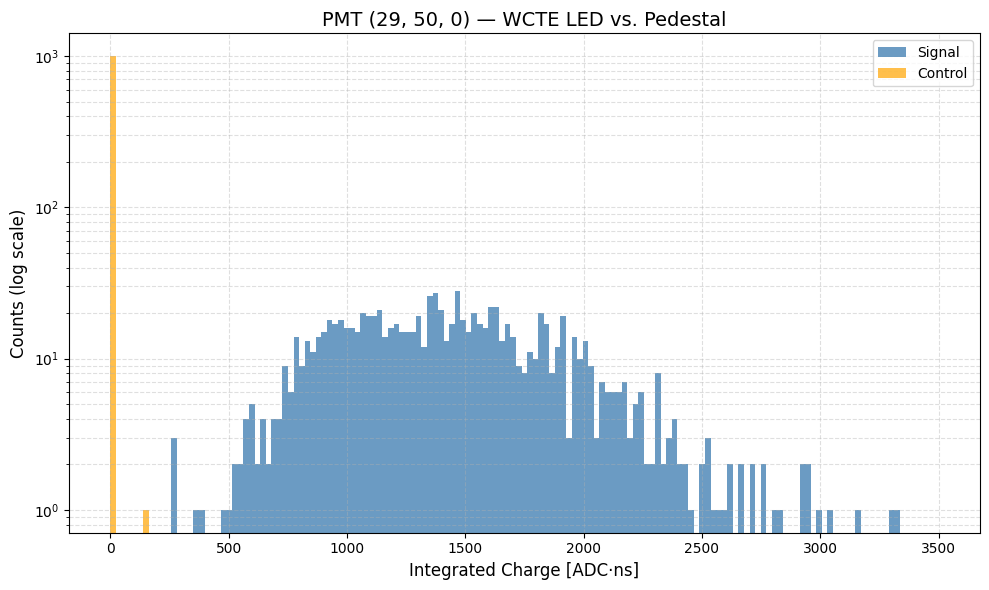

In [ ]:
# === Choose a single PMT within the chosen mPMT ===
pmt_id = (29, 50, 0)  # Change the channel ID (last number) if needed

# Extract charge arrays
signal = data_charges.get(pmt_id, [])
control = ctrl_charges.get(pmt_id, [])

# Safety printout
print(f"Signal entries: {len(signal)}")
print(f"Signal charge range: {np.min(signal) if signal else 'N/A'} → {np.max(signal) if signal else 'N/A'}")
print(f"Control entries: {len(control)}")
print(f"Control charge range: {np.min(control) if control else 'N/A'} → {np.max(control) if control else 'N/A'}")

# === Define histogram bins based on the full charge range ===
all_charges = signal + control
if not all_charges:
    print("⚠️ No data to plot.")
else:
    min_bin = min(np.min(all_charges), 0)
    max_bin = max(np.max(all_charges), 3500)
    bins = np.linspace(min_bin, max_bin, 150)

    # === Plot (log y-scale only) ===
    plt.figure(figsize=(10, 6))
    plt.hist(signal, bins=bins, histtype='stepfilled', label='Signal', color='steelblue', alpha=0.8)
    plt.hist(control, bins=bins, histtype='stepfilled', label='Control', color='orange', alpha=0.7)
    plt.yscale('log')
    plt.xlabel("Integrated Charge [ADC·ns]", fontsize=12)
    plt.ylabel("Counts (log scale)", fontsize=12)
    plt.title(f"PMT {pmt_id} — WCTE LED vs. Pedestal", fontsize=14)
    plt.grid(True, which='both', linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


⚠️ Not enough data points to fit pedestal.


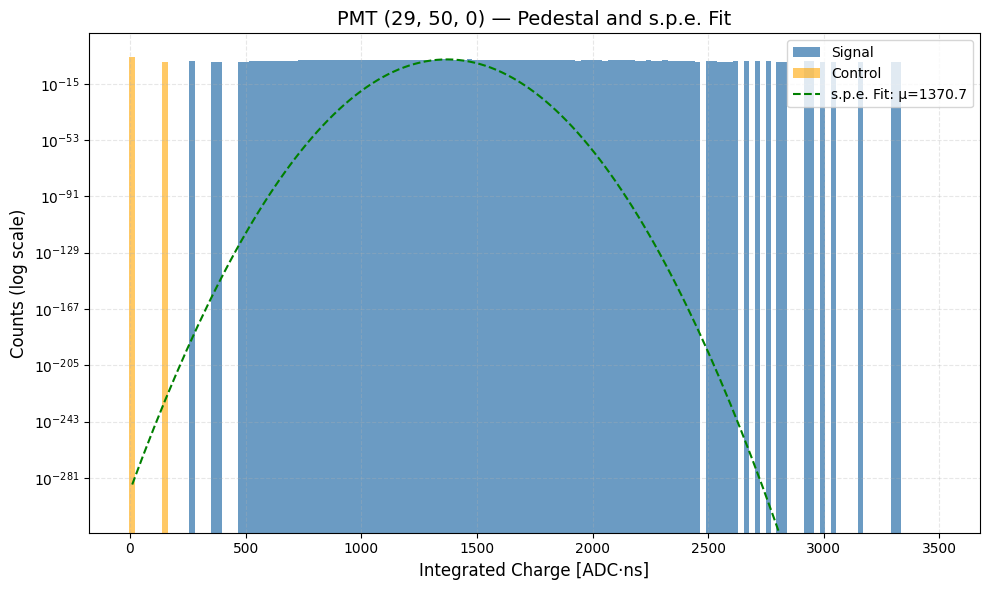

s.p.e. mean: 1370.66 ADC·ns


TypeError: 'NoneType' object is not subscriptable

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

# === Gaussian function ===
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# === Select a PMT ===
pmt_id = (29, 50, 0)
signal = data_charges.get(pmt_id, [])
control = ctrl_charges.get(pmt_id, [])

# === Combine for bin range ===
all_charges = signal + control
min_bin = min(np.min(all_charges), 0)
max_bin = max(np.max(all_charges), 3500)
bins = np.linspace(min_bin, max_bin, 150)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# === Histogram data ===
ctrl_hist, _ = np.histogram(control, bins=bins)
sig_hist, _ = np.histogram(signal, bins=bins)

# === Fit pedestal (control) ===
ctrl_smooth = gaussian_filter1d(ctrl_hist, sigma=1.5)
ped_peak_idx = np.argmax(ctrl_smooth)
ped_mu_guess = bin_centers[ped_peak_idx]
ped_A_guess = ctrl_smooth[ped_peak_idx]
ped_sigma_guess = 10

ped_fit_mask = (bin_centers > ped_mu_guess - 30) & (bin_centers < ped_mu_guess + 30)
x_fit_ped = bin_centers[ped_fit_mask]
y_fit_ped = ctrl_hist[ped_fit_mask]

if len(x_fit_ped) >= 5:
    try:
        popt_ped, _ = curve_fit(
            gaussian,
            x_fit_ped,
            y_fit_ped,
            p0=[ped_A_guess, ped_mu_guess, ped_sigma_guess]
        )
    except RuntimeError:
        popt_ped = None
else:
    print("⚠️ Not enough data points to fit pedestal.")
    popt_ped = None


# === Fit s.p.e. peak (signal), excluding pedestal ===
spe_mask = bin_centers > 150  # exclude pedestal
sig_smooth = gaussian_filter1d(sig_hist, sigma=1.5)
spe_peak_idx = np.argmax(sig_smooth[spe_mask])
spe_mu_guess = bin_centers[spe_mask][spe_peak_idx]
spe_A_guess = sig_smooth[spe_mask][spe_peak_idx]
spe_sigma_guess = 30

spe_fit_mask = (bin_centers > spe_mu_guess - 50) & (bin_centers < spe_mu_guess + 50)
try:
    popt_spe, _ = curve_fit(
        gaussian,
        bin_centers[spe_fit_mask],
        sig_hist[spe_fit_mask],
        p0=[spe_A_guess, spe_mu_guess, spe_sigma_guess]
    )
except RuntimeError:
    popt_spe = None

# === Plot ===
plt.figure(figsize=(10, 6))
plt.hist(signal, bins=bins, histtype='stepfilled', label='Signal', color='steelblue', alpha=0.8)
plt.hist(control, bins=bins, histtype='stepfilled', label='Control', color='orange', alpha=0.6)
plt.yscale('log')
plt.xlabel("Integrated Charge [ADC·ns]", fontsize=12)
plt.ylabel("Counts (log scale)", fontsize=12)
plt.title(f"PMT {pmt_id} — Pedestal and s.p.e. Fit", fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.3)

# --- Plot fits ---
if popt_ped is not None:
    ped_fit_curve = gaussian(bin_centers, *popt_ped)
    plt.plot(bin_centers, ped_fit_curve, 'r--', label=f'Pedestal Fit: μ={popt_ped[1]:.1f}')

if popt_spe is not None:
    spe_fit_curve = gaussian(bin_centers, *popt_spe)
    plt.plot(bin_centers, spe_fit_curve, 'g--', label=f's.p.e. Fit: μ={popt_spe[1]:.1f}')

plt.legend()
plt.tight_layout()
plt.show()

# === Report peak positions ===
if popt_ped is not None:
    print(f"Pedestal mean: {popt_ped[1]:.2f} ADC·ns")
if popt_spe is not None:
    print(f"s.p.e. mean: {popt_spe[1]:.2f} ADC·ns")
    print(f"PMT Gain (μ_spe - μ_ped): {popt_spe[1] - popt_ped[1]:.2f} ADC·ns")

In [ ]:
chosen_pmt = (29, 50, 10)
charges = charges_per_pmt.get(chosen_pmt, [])

if len(charges) < 100:
    print(f"Too few entries for PMT {chosen_pmt}")
else:
    hist, bins = np.histogram(charges, bins=100)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Initial peak guess from max bin
    peak_bin_idx = np.argmax(hist)
    
    # Define window around peak: 5 bins left, 2 bins right (total 8 bins)
    left_idx = max(0, peak_bin_idx - 5)
    right_idx = min(len(hist) - 1, peak_bin_idx + 2)
    
    # Restrict histogram and bin centers to the window
    hist_window = hist[left_idx:right_idx+1]
    bin_centers_window = bin_centers[left_idx:right_idx+1]
    
    # Initial guess for fit parameters within the window
    A_guess = np.max(hist_window)
    mu_guess = bin_centers[peak_bin_idx]  # peak location
    sigma_guess = np.std(charges)

    try:
        popt, _ = curve_fit(single_gaussian, bin_centers_window, hist_window, p0=[A_guess, mu_guess, sigma_guess])
        fit_curve = single_gaussian(bin_centers_window, *popt)

        plt.figure(figsize=(8,6))
        plt.hist(charges, bins=100, histtype='step', label="Data")
        plt.plot(bin_centers_window, fit_curve, label="Gaussian fit")
        plt.axvline(popt[1], color='orange', linestyle='--', label=f"s.p.e. peak = {popt[1]:.2f}")
        plt.title(f"Charge Spectrum and s.p.e. Fit for PMT {chosen_pmt}")
        plt.xlabel("Charge (ADC units)")
        plt.ylabel("Counts")
        plt.legend()
        plt.grid()
        plt.show()

        print(f"Fitted mean s.p.e. peak (mu) for PMT {chosen_pmt}: {popt[1]:.2f} ADC units")

    except RuntimeError:
        print(f"Fit failed for PMT {chosen_pmt}")


NameError: name 'single_gaussian' is not defined

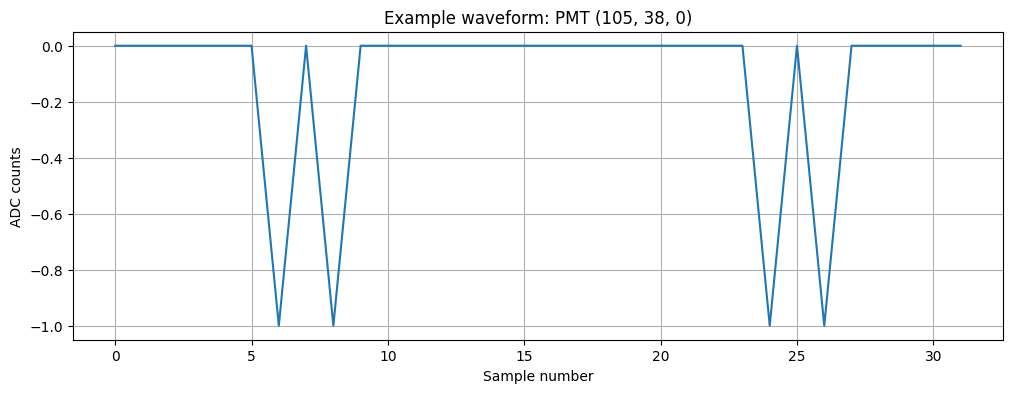

In [ ]:
example_pmt = list(waveforms_per_pmt.keys())[0]
example_waveform = waveforms_per_pmt[example_pmt][0]

plt.figure(figsize=(12, 4))
plt.plot(example_waveform[:500])
plt.title(f"Example waveform: PMT {example_pmt}")
plt.xlabel("Sample number")
plt.ylabel("ADC counts")
plt.grid()
plt.show()

In [ ]:
def integrate_waveform(wf, window=(0, None)):
    if window[1] is None:
        window = (window[0], len(wf))
    return -np.sum(wf[window[0]:window[1]])

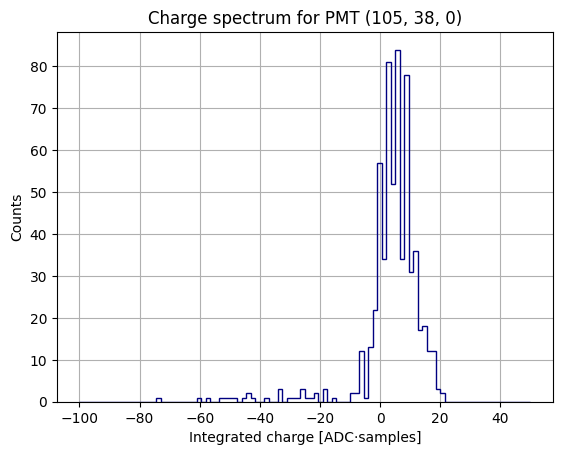

In [ ]:
example_pmt = list(waveforms_per_pmt.keys())[0]
charges = [integrate_waveform(wf, window=(10, 80)) for wf in waveforms_per_pmt[example_pmt]]

plt.hist(charges, bins=100, range=(-100, 50), histtype="step", color="navy")
plt.title(f"Charge spectrum for PMT {example_pmt}")
plt.xlabel("Integrated charge [ADC·samples]")
plt.ylabel("Counts")
plt.grid()
plt.show()

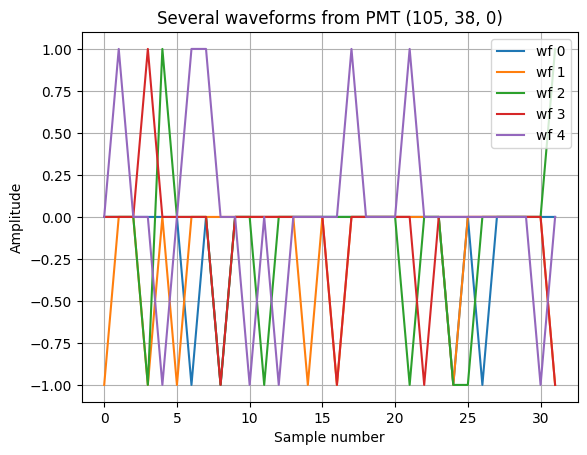

In [ ]:
for i in range(5):
    plt.plot(waveforms_per_pmt[example_pmt][i], label=f"wf {i}")
plt.title(f"Several waveforms from PMT {example_pmt}")
plt.xlabel("Sample number")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [ ]:
def integrate_around_peak(wf, peak_width=20):
    # Invert waveform to find valley as positive peak
    inv_wf = -np.array(wf)
    peak_index = np.argmax(inv_wf)

    # Define integration window around the pulse
    start = max(0, peak_index - peak_width // 2)
    end = min(len(wf), peak_index + peak_width // 2)
    
    # Integrate (using inverted to make result positive)
    charge = -np.sum(wf[start:end])
    return charge

charges = [integrate_around_peak(wf) for wf in waveforms_per_pmt[example_pmt]]
print(charges)
print(len(charges))

[2.0, 3.0, 2.0, 1.0, -0.0, 4.0, -1.0, -3.0, 1.0, -1.0, -2.0, 2.0, 3.0, 5.0, 3.0, 2.0, 5.0, 3.0, -1.0, 4.0, -5.0, 3.0, -1.0, -0.0, -3.0, 2.0, -19.0, 4.0, 2.0, 4.0, 1.0, 2.0, -5.0, 4.0, 7.0, -0.0, 3.0, 5.0, -2.0, -2.0, -30.0, 9.0, 2.0, 3.0, 3.0, -81.0, -1.0, 1.0, 4.0, 2.0, 3.0, 2.0, -3.0, 2.0, -2.0, 3.0, 2.0, 5.0, 3.0, 2.0, 1.0, 2.0, -0.0, 4.0, -74.0, -45.0, 6.0, 3.0, 3.0, 5.0, 4.0, 5.0, 4.0, -1.0, 3.0, 1.0, 1.0, 2.0, -1.0, 5.0, 2.0, -0.0, 2.0, 2.0, -1.0, 10.0, 3.0, 6.0, 2.0, 4.0, 5.0, 3.0, 6.0, 3.0, -31.0, 4.0, 2.0, 1.0, 3.0, 3.0, 3.0, 6.0, 5.0, 2.0, 10.0, 6.0, 2.0, -1.0, -0.0, 4.0, 2.0, 8.0, 8.0, 8.0, -35.0, 1.0, 6.0, 8.0, 2.0, 5.0, -0.0, 4.0, 1.0, 2.0, 11.0, 13.0, 7.0, 4.0, 1.0, 9.0, 3.0, -61.0, 2.0, 8.0, -96.0, 7.0, 2.0, 9.0, 4.0, 14.0, 3.0, 5.0, 4.0, 4.0, 4.0, -0.0, 9.0, 1.0, 4.0, 3.0, 4.0, 4.0, 8.0, 8.0, 8.0, 4.0, 6.0, 2.0, 6.0, 1.0, 5.0, 6.0, 6.0, 8.0, 1.0, 4.0, 5.0, 2.0, 3.0, -116.0, 3.0, 5.0, -0.0, 3.0, 4.0, 2.0, -0.0, 4.0, 1.0, 6.0, 2.0, -3.0, -2.0, -0.0, 8.0, -33.0, 5.0, 8.0, 

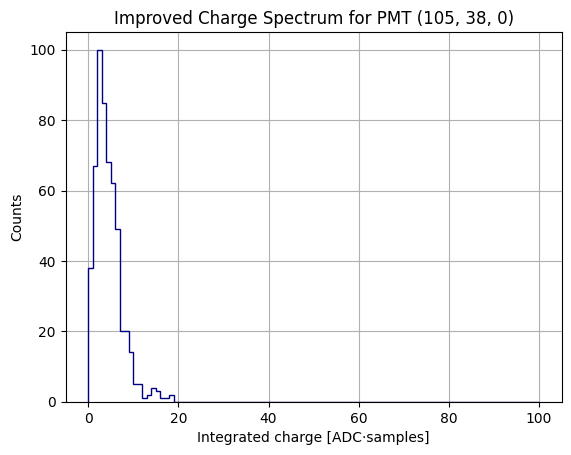

In [ ]:
plt.hist(charges, bins=100, range=(0, 100), histtype="step", color="navy")
plt.title(f"Improved Charge Spectrum for PMT {example_pmt}")
plt.xlabel("Integrated charge [ADC·samples]")
plt.ylabel("Counts")
plt.grid()
plt.show()

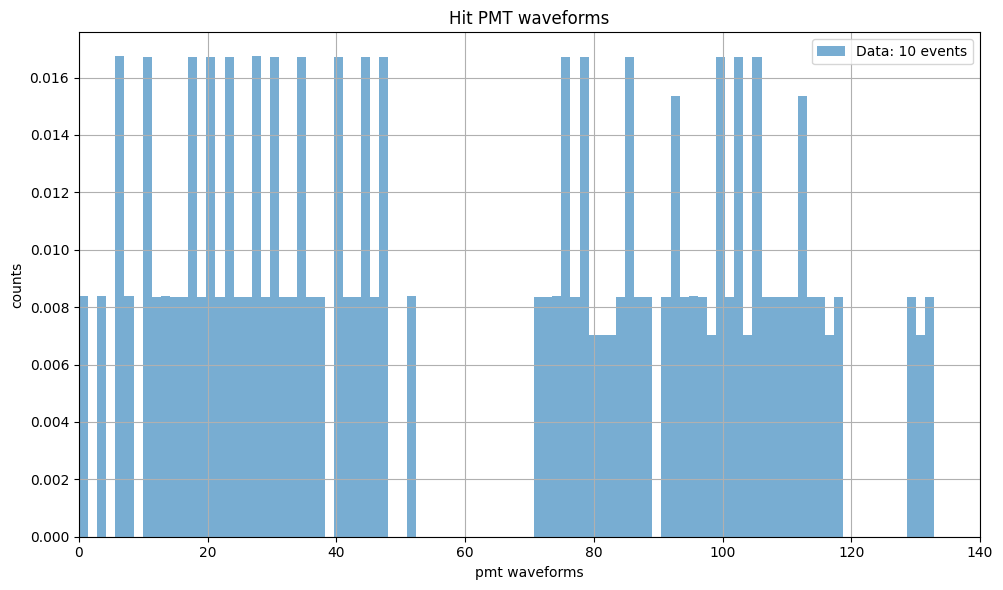

In [ ]:
data_wave = ak.flatten(data["pmt_waveform_mpmt_card_ids"], axis=None)


min_range_wave = 0
max_range_wave = 140

data_charges = data_wave[(data_wave >= min_range_wave) & (data_wave <= max_range_wave)]

bins = np.linspace(min_range_wave, max_range_wave, 100)

plt.figure(figsize=(10, 6))
plt.hist(data_charges, bins=bins, alpha=0.6, label=f'Data: {len(data)} events', histtype='stepfilled', density=True)

plt.title('Hit PMT waveforms')
plt.xlabel('pmt waveforms')
plt.ylabel('counts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min_range_wave, max_range_wave)

plt.show()